In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import pickle
from torch.optim.lr_scheduler import StepLR

import torch
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import pickle

import gymnasium as gym
import highway_env

### T-REX model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist

class Net(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=64, encoding_dims=10, action_dims=5):
        super(Net, self).__init__()
        
        # Encoder (MLP for flattened 5x5 state)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # input_dim = 5 * 5 = 25
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, encoding_dims)
        self.fc_var = nn.Linear(hidden_dim, encoding_dims)  # Outputs log-variance
        
        # Decoder (reconstructs flattened 5x5 state)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dims, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # Output 25-dim state
        )

        # Reward predictor
        self.fc_reward = nn.Linear(encoding_dims, 1)

        # Temporal difference
        self.temporal_difference = nn.Linear(2 * encoding_dims, 1, bias=False)
        
        # Inverse dynamics (predicts 5 discrete actions)
        self.inverse_dynamics = nn.Linear(2 * encoding_dims, action_dims, bias=False)
        
        # Forward dynamics (takes 5-dim one-hot actions)
        self.forward_dynamics = nn.Linear(encoding_dims + action_dims, encoding_dims, bias=False)
        
        # Normal distribution for VAE reparameterization
        self.normal = tdist.Normal(0, 1)
        
        # Device setup
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def reparameterize(self, mu, var):
        """Reparameterize for VAE: z = mu + std * eps"""
        if self.training:
            std = var.mul(0.5).exp()
            eps = self.normal.sample(mu.shape).to(self.device)
            return eps.mul(std).add(mu)
        else:
            return mu

    def encode(self, x):
        """Encode state to latent space"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        var = self.fc_var(h)  # Log-variance
        z = self.reparameterize(mu, var)
        return z, mu, var
    
    def decode(self, z):
        """Decode latent encoding to reconstructed state"""
        return self.decoder(z)
    
    def predict_reward(self, z):
        """Predict per-frame reward from latent encoding"""
        return self.fc_reward(z)
    
    def estimate_temporal_difference(self, z1, z2):
        """Predict time difference between two latent encodings"""
        x = torch.cat((z1, z2), dim=1)
        return self.temporal_difference(x)
 
    def estimate_inverse_dynamics(self, z1, z2):
        """Predict action (logits for 5 actions) from two consecutive latent encodings"""
        x = torch.cat((z1, z2), dim=1)
        return self.inverse_dynamics(x)

    def estimate_forward_dynamics(self, z1, action):
        """Predict next latent encoding from current encoding and one-hot action"""
        x = torch.cat((z1, action), dim=1)
        return self.forward_dynamics(x)

    def cum_return(self, traj):
        """Calculate cumulative return and related outputs for a trajectory"""
        # Reshape traj from (T, 1, 5, 5) to (T, 25)
        traj = traj.view(traj.size(0), -1)  # Shape: (T, 25)
        z, mu, var = self.encode(traj)  # Shape: (T, encoding_dims)
        rewards = self.predict_reward(z)  # Shape: (T, 1)
        sum_rewards = torch.sum(rewards)  # Scalar
        sum_abs_rewards = torch.sum(torch.abs(rewards))  # Scalar
        return sum_rewards, sum_abs_rewards, z, mu, var
    
    def forward(self, traj_i, traj_j):
        """Compute outputs for two trajectories (for T-REX ranking)"""
        # Compute cumulative returns and latent encodings
        cum_r_i, abs_r_i, z_i, mu_i, var_i = self.cum_return(traj_i)  # traj_i: (T_i, 1, 5, 5)
        cum_r_j, abs_r_j, z_j, mu_j, var_j = self.cum_return(traj_j)  # traj_j: (T_j, 1, 5, 5)
        
        # Reconstructed states
        recon_i = self.decode(z_i)  # Shape: (T_i, 25)
        recon_j = self.decode(z_j)  # Shape: (T_j, 25)
        
        # Return logits for ranking, absolute rewards, and latent encodings
        return (
            torch.cat((cum_r_i.unsqueeze(0), cum_r_j.unsqueeze(0)), 0),  # Logits for ranking
            abs_r_i + abs_r_j,  # Sum of absolute rewards
            z_i, z_j, mu_i, mu_j, var_i, var_j,  # Latent encodings
            recon_i, recon_j  # Reconstructed states
        )

### Data preparation function

In [8]:
def create_training_data_for_preferences(segments, preferences):
    """
    Prepare training data using full segments and provided pairwise preferences.
    
    Args:
        segments: List of segments, each a list of (state, action, reward, done) tuples.
        preferences: List of (seg_i, seg_j, label) tuples, where label=1 means seg_i is better.
    
    Returns:
        training_obs: List of (traj_i, traj_j) tuples, each traj of shape (T', 1, 5, 5).
        training_labels: List of binary labels (1 if traj_i better, 0 if traj_j better).
        times: List of (time_i, time_j) tuples, where time_i, time_j are lists of indices.
        actions: List of (actions_i, actions_j) tuples, each of shape (T', 5).
    """
    max_traj_length = 0
    training_obs = []
    training_labels = []
    times = []
    actions = []
    
    for seg_i_idx, seg_j_idx, label in preferences:
        # Get segments
        seg_i = segments[seg_i_idx]
        seg_j = segments[seg_j_idx]
        
        # Extract full trajectories (all steps, ignoring done)
        traj_i = np.array([seg_i[i][0] for i in range(len(seg_i))])  # Shape: (T_i', 1, 5, 5)
        traj_j = np.array([seg_j[i][0] for i in range(len(seg_j))])  # Shape: (T_j', 1, 5, 5)
        actions_i = np.array([seg_i[i][1] for i in range(len(seg_i))])  # Shape: (T_i', 5)
        actions_j = np.array([seg_j[i][1] for i in range(len(seg_j))])  # Shape: (T_j', 5)
        
        # Store data
        training_obs.append((traj_i, traj_j))
        training_labels.append(label)  # 0 if seg_i better, 1 if seg_j better
        times.append((list(range(len(seg_i))), list(range(len(seg_j)))))  # All indices
        actions.append((actions_i, actions_j))
        max_traj_length = max(max_traj_length, len(traj_i), len(traj_j))
    
    print("maximum traj length", max_traj_length)
    return training_obs, training_labels, times, actions

def create_training_data_for_corrections(corrections):
    """
    Prepare training data using correction feedback pairs.
    
    Args:
        corrections: List of (worse_segment, better_segment) tuples, where each segment is a list of (state, action, reward, done) tuples.
    
    Returns:
        training_obs: List of (traj_i, traj_j) tuples, where traj_i is from better_segment, traj_j from worse_segment, each traj of shape (T', 1, 5, 5).
        training_labels: List of binary labels (1 meaning traj_i is better).
        times: List of (time_i, time_j) tuples, where time_i, time_j are lists of indices.
        actions: List of (actions_i, actions_j) tuples, each of shape (T', 5).
    """
    max_traj_length = 0
    training_obs = []
    training_labels = []
    times = []
    actions = []
    
    for worse_seg, better_seg in corrections:
  
        traj_i = np.array([better_seg[i][0] for i in range(len(better_seg))])  # better: Shape: (T_i', 1, 5, 5)
        traj_j = np.array([worse_seg[i][0] for i in range(len(worse_seg))])  # worse: Shape: (T_j', 1, 5, 5)
        actions_i = np.array([better_seg[i][1] for i in range(len(better_seg))])  # Shape: (T_i', 5)
        actions_j = np.array([worse_seg[i][1] for i in range(len(worse_seg))])  # Shape: (T_j', 5)
        
        # Store data
        training_obs.append((traj_i, traj_j))
        training_labels.append(1)  # 1 since traj_i (better) is preferred
        times.append((list(range(len(better_seg))), list(range(len(worse_seg)))))  # All indices
        actions.append((actions_i, actions_j))
        max_traj_length = max(max_traj_length, len(traj_i), len(traj_j))
    
    print("maximum traj length", max_traj_length)
    return training_obs, training_labels, times, actions


### Training loop

#### To do
- In correction feedback we have trajs with length one, I should change the dynamics for them, beacuse dynamics need traj with at least len 2

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import wandb

def reconstruction_loss(decoded, target, mu, logvar):
    """Compute reconstruction loss (MSE + KL-divergence) for VAE."""
    mse = F.mse_loss(decoded, target, reduction='sum') / target.numel()
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / target.numel()
    return mse + kld

def learn_reward(reward_network, optimizer, training_inputs, training_outputs, training_times, training_actions, num_iter, l1_reg, checkpoint_dir, loss_fn, wandb_project_name):
    """
    Train the reward network using T-REX and self-supervised losses, logging to W&B.
    
    Args:
        reward_network: Net model instance (input_dim=25, action_dims=5).
        optimizer: PyTorch optimizer (e.g., Adam).
        training_inputs: List of (traj_i, traj_j) tuples, each traj of shape (T', 1, 5, 5).
        training_outputs: List of binary labels (1 if traj_i better, 0 if traj_j better).
        training_times: List of (time_i, time_j) tuples.
        training_actions: List of (actions_i, actions_j) tuples, each of shape (T', 5).
        num_iter: Number of epochs.
        l1_reg: L1 regularization weight (unused).
        checkpoint_dir: Path to save model checkpoints.
        loss_fn: Loss function type ('trex', 'ss', 'trex+ss').
    
    Returns:
        reward_network: Trained Net model.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    # Initialize W&B
    wandb.init(project=wandb_project_name, config={
        "num_iter": num_iter,
        "loss_fn": loss_fn,
        "lr": optimizer.param_groups[0]['lr'],
        "weight_decay": optimizer.param_groups[0].get('weight_decay', 0.0)
    })
    
    loss_criterion = nn.CrossEntropyLoss()
    temporal_difference_loss = nn.MSELoss()
    inverse_dynamics_loss = nn.CrossEntropyLoss()
    forward_dynamics_loss = nn.MSELoss()
    
    training_data = list(zip(training_inputs, training_outputs, training_times, training_actions))
    for epoch in range(num_iter):
        np.random.shuffle(training_data)
        cum_loss = 0.0
        cum_trex_loss = 0.0
        cum_recon_loss = 0.0
        cum_inv_loss = 0.0
        cum_fwd_loss = 0.0
        cum_dt_loss = 0.0
        
        for i, (obs, label, times, actions) in enumerate(training_data):
            traj_i, traj_j = torch.tensor(obs[0], dtype=torch.float32).to(device), torch.tensor(obs[1], dtype=torch.float32).to(device)  # (T_i', 1, 5, 5), (T_j', 1, 5, 5)
            label = torch.tensor([label], dtype=torch.long).to(device)  # 1 if traj_i better
            actions_i, actions_j = torch.tensor(actions[0], dtype=torch.float32).to(device), torch.tensor(actions[1], dtype=torch.float32).to(device)  # (T_i', 5), (T_j', 5)
            times_i, times_j = times
            
            #if len(traj_i) < 2 or len(traj_j) < 2:  # Need at least 2 steps for dynamics
            #    continue
            ## I should change 
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs, abs_rewards, z1, z2, mu1, mu2, var1, var2, recon_i, recon_j = reward_network(traj_i, traj_j)
            
            # Reconstruction loss (MSE + KL-divergence)
            recon_loss_i = reconstruction_loss(recon_i, traj_i.view(traj_i.size(0), -1), mu1, var1)
            recon_loss_j = reconstruction_loss(recon_j, traj_j.view(traj_j.size(0), -1), mu2, var2)
            recon_loss = 10 * (recon_loss_i + recon_loss_j)
            
            # Inverse dynamics
            actions_1 = reward_network.estimate_inverse_dynamics(mu1[:-1], mu1[1:])  # (T_i'-1, 5)
            actions_2 = reward_network.estimate_inverse_dynamics(mu2[:-1], mu2[1:])  # (T_j'-1, 5)
            target_actions_1 = torch.argmax(actions_i[1:], dim=1)  # Convert one-hot to indices
            target_actions_2 = torch.argmax(actions_j[1:], dim=1)
            inv_loss = (inverse_dynamics_loss(actions_1, target_actions_1) + inverse_dynamics_loss(actions_2, target_actions_2)) / 1.9
            
            # Forward dynamics (single-step)
            forward_dynamics_1 = reward_network.estimate_forward_dynamics(mu1[:-1], actions_i[:-1])  # (T_i'-1, encoding_dims)
            forward_dynamics_2 = reward_network.estimate_forward_dynamics(mu2[:-1], actions_j[:-1])  # (T_j'-1, encoding_dims)
            fwd_loss = 100 * (forward_dynamics_loss(forward_dynamics_1, mu1[1:]) + forward_dynamics_loss(forward_dynamics_2, mu2[1:]))
            
            # Temporal difference
            t1_i, t2_i = np.random.randint(0, len(times_i)), np.random.randint(0, len(times_i))
            t1_j, t2_j = np.random.randint(0, len(times_j)), np.random.randint(0, len(times_j))
            est_dt_i = reward_network.estimate_temporal_difference(mu1[t1_i].unsqueeze(0), mu1[t2_i].unsqueeze(0))
            est_dt_j = reward_network.estimate_temporal_difference(mu2[t1_j].unsqueeze(0), mu2[t2_j].unsqueeze(0))
            real_dt_i = (times_i[t2_i] - times_i[t1_i]) / 100.0
            real_dt_j = (times_j[t2_j] - times_j[t1_j]) / 100.0
            dt_loss = 4 * (temporal_difference_loss(est_dt_i, torch.tensor([[real_dt_i]], dtype=torch.float32, device=device)) +
                           temporal_difference_loss(est_dt_j, torch.tensor([[real_dt_j]], dtype=torch.float32, device=device)))
            
            # T-REX loss
            trex_loss = loss_criterion(outputs.unsqueeze(0), label)
            
            # Combine losses
            if loss_fn == "trex":
                loss = trex_loss
            elif loss_fn == "ss":
                loss = recon_loss + inv_loss + fwd_loss + dt_loss
            elif loss_fn == "trex+ss":
                loss = trex_loss + recon_loss + inv_loss + fwd_loss + dt_loss
            
            loss.backward()
            optimizer.step()
            
            # Log losses to W&B
            wandb.log({
                "epoch": epoch,
                "iteration": i,
                "total_loss": loss.item(),
                "trex_loss": trex_loss.item(),
                "reconstruction_loss": recon_loss.item(),
                "inverse_dynamics_loss": inv_loss.item(),
                "forward_dynamics_loss": fwd_loss.item(),
                "temporal_difference_loss": dt_loss.item()
            })
            
            cum_loss += loss.item()
            cum_trex_loss += trex_loss.item()
            cum_recon_loss += recon_loss.item()
            cum_inv_loss += inv_loss.item()
            cum_fwd_loss += fwd_loss.item()
            cum_dt_loss += dt_loss.item()
            
            if i % 500 == 499:
                avg_loss = cum_loss / 500
                avg_trex_loss = cum_trex_loss / 500
                avg_recon_loss = cum_recon_loss / 500
                avg_inv_loss = cum_inv_loss / 500
                avg_fwd_loss = cum_fwd_loss / 500
                avg_dt_loss = cum_dt_loss / 500
                print(f"epoch {epoch}:{i} total_loss {avg_loss:.4f} "
                      f"trex {avg_trex_loss:.4f} recon {avg_recon_loss:.4f} "
                      f"inv {avg_inv_loss:.4f} fwd {avg_fwd_loss:.4f} dt {avg_dt_loss:.4f}")
                wandb.log({
                    "epoch": epoch,
                    "iteration": i,
                    "avg_total_loss": avg_loss,
                    "avg_trex_loss": avg_trex_loss,
                    "avg_reconstruction_loss": avg_recon_loss,
                    "avg_inverse_dynamics_loss": avg_inv_loss,
                    "avg_forward_dynamics_loss": avg_fwd_loss,
                    "avg_temporal_difference_loss": avg_dt_loss
                })
                cum_loss = 0.0
                cum_trex_loss = 0.0
                cum_recon_loss = 0.0
                cum_inv_loss = 0.0
                cum_fwd_loss = 0.0
                cum_dt_loss = 0.0
                torch.save(reward_network.state_dict(), checkpoint_dir)
    
    print("finished training")
    return reward_network

### Loading the data

In [20]:
# Load feedback data
feedback_path = 'ppo_roundabout-v0_1377.pkl'

with open(feedback_path, 'rb') as file:
    feedback_data = pickle.load(file)

segments = feedback_data['segments']
demos = feedback_data['demos']
preferences = feedback_data['preferences']
corrections = feedback_data['corrections']


In [21]:
len(preferences)

600

In [4]:
for correction in corrections:
    print(len(correction[0][0]))


#len(corrections[0][0][0])

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
4
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5


In [30]:
corrections[0][1]

[(array([[[ 1.0000000e+00,  1.0000000e+00,  5.0000000e-01,  2.5000000e-01,
            0.0000000e+00],
          [ 1.0000000e+00,  6.5435916e-02, -5.0000000e-01,  1.6522936e-05,
            0.0000000e+00],
          [ 1.0000000e+00,  1.4763670e-01,  0.0000000e+00,  1.3565752e-05,
            0.0000000e+00],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
            0.0000000e+00],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
            0.0000000e+00]]], dtype=float32),
  array([0., 1., 0., 0., 0.]),
  0.8888888891249783,
  True),
 (array([[[ 1.        ,  0.15      ,  0.5       ,  0.375     ,
            0.        ],
          [ 1.        ,  0.17514642,  0.        ,  0.00396742,
            0.        ],
          [ 1.        ,  0.27960327, -0.5       , -0.02131613,
            0.        ],
          [ 1.        ,  0.4       ,  1.        , -0.125     ,
            0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.

In [25]:
for i in range(0, 10, 100):
    print(corrections[1])
    break

([(array([[[ 1.0000000e+00,  1.0000000e+00,  5.0000000e-01,  2.5000030e-01,
          0.0000000e+00],
        [ 1.0000000e+00,  3.1123919e-02, -1.7972669e-02, -7.4623376e-02,
          4.7270949e-03],
        [ 1.0000000e+00,  1.4058515e-01, -4.9941915e-01, -9.9740596e-03,
         -1.6720012e-04],
        [ 1.0000000e+00,  2.1489862e-01,  2.1316204e-04, -5.6697777e-03,
         -6.1606326e-05],
        [ 1.0000000e+00,  2.4500008e-01,  5.0000000e-01, -2.5000030e-01,
          0.0000000e+00]]], dtype=float32), array([1., 0., 0., 0., 0.]), 0.13181586689281316, True, 0)], [(array([[[ 1.0000000e+00,  1.0000000e+00,  5.0000000e-01,  2.5000000e-01,
          0.0000000e+00],
        [ 1.0000000e+00,  1.4385621e-01, -5.0000000e-01,  1.3172857e-05,
          0.0000000e+00],
        [ 1.0000000e+00,  1.6139020e-01,  2.2602894e-08, -5.0579623e-04,
         -6.5621522e-09],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00],
        [ 0.0000000e+00, 

### Making the correct order based on the cummulative reward

In [10]:
def process_preferences(preferences, segments):
    """
    Process preferences by comparing segment rewards and creating debugged preferences.
    
    Args:
        preferences: List of tuples (seg_i_idx, seg_j_idx, label)
        segments: List of segments containing reward data
    
    Returns:
        List of debugged preferences as tuples (seg_i_idx, seg_j_idx, 1)
    """
    debugged_preferences = []
    for seg_i_idx, seg_j_idx, label in preferences:
        # Get segments
        seg_i = segments[seg_i_idx]
        seg_j = segments[seg_j_idx]

        # Extract rewards
        rewards_i = [r for _, _, r, _ in seg_i]  # Shape: List of scalars
        rewards_j = [r for _, _, r, _ in seg_j]  # Shape: List of scalars
        
        # Compare sum of rewards
        if np.sum(rewards_i) == np.sum(rewards_j):
            print("equal")
            print(np.sum(rewards_i), " ", np.sum(rewards_j))
        elif np.sum(rewards_i) > np.sum(rewards_j):
            debugged_preferences.append((seg_i_idx, seg_j_idx, 0))
        elif np.sum(rewards_i) < np.sum(rewards_j):
            debugged_preferences.append((seg_j_idx, seg_i_idx, 0))
    
    return debugged_preferences

preferences = process_preferences(preferences, segments)
training_obs, training_labels, times, actions = create_training_data_for_preferences(segments, preferences)
#training_obs, training_labels, times, actions = create_training_data_for_corrections(corrections)

equal
14.939567778938978   14.939567778938978
equal
14.856234445605644   14.856234445605644
equal
14.467345556716754   14.467345556716754
maximum traj length 17


In [9]:

# Initialize model and optimizer
reward_net = Net(input_dim=25, hidden_dim=64, encoding_dims=10, action_dims=5)
optimizer = optim.Adam(reward_net.parameters(), lr=0.0001, weight_decay=0.001)

# Train and get the trained model
trained_model = learn_reward(
    reward_network=reward_net,
    optimizer=optimizer,
    training_inputs=training_obs,
    training_outputs=training_labels,
    training_times=times,
    training_actions=actions,
    num_iter=10,
    l1_reg=0.0,
    checkpoint_dir="preference_model.pth",
    loss_fn="trex+ss",
    wandb_project_name="preference_model"
)

cuda:0


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alilarian23 (a7a7) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch 0:499 total_loss 7.2034 trex 1.4687 recon 2.5114 inv 1.6674 fwd 1.5139 dt 0.0420
epoch 0:999 total_loss 5.0563 trex 1.4379 recon 1.2214 inv 1.6304 fwd 0.7328 dt 0.0338
epoch 0:1499 total_loss 4.4935 trex 1.3020 recon 1.1899 inv 1.5337 fwd 0.4383 dt 0.0296
epoch 0:1999 total_loss 3.8764 trex 0.9623 recon 1.2333 inv 1.3534 fwd 0.2988 dt 0.0287
epoch 0:2499 total_loss 3.6756 trex 0.9139 recon 1.2644 inv 1.2461 fwd 0.2202 dt 0.0310
epoch 0:2999 total_loss 3.4339 trex 0.7647 recon 1.2547 inv 1.2013 fwd 0.1826 dt 0.0305
epoch 0:3499 total_loss 3.4184 trex 0.8008 recon 1.2315 inv 1.1853 fwd 0.1694 dt 0.0314
epoch 0:3999 total_loss 3.2523 trex 0.6984 recon 1.2091 inv 1.1648 fwd 0.1486 dt 0.0314
epoch 0:4499 total_loss 3.2037 trex 0.6570 recon 1.2011 inv 1.1685 fwd 0.1448 dt 0.0322
epoch 0:4999 total_loss 3.2520 trex 0.7440 recon 1.1871 inv 1.1482 fwd 0.1406 dt 0.0321
epoch 0:5499 total_loss 3.1846 trex 0.6931 recon 1.1735 inv 1.1609 fwd 0.1247 dt 0.0323
epoch 0:5999 total_loss 3.1226 tre

## Prediction functions

In [11]:
import torch
import numpy as np
import wandb

def predict_reward_sequence(net, segment, log_to_wandb=False):
    """
    Predict per-state rewards for a segment from the Highway environment and extract true rewards.
    
    Args:
        net: Net model instance (input_dim=25, action_dims=5).
        segment: List of (state, action, reward, done) tuples, where state has shape (1, 5, 5).
        log_to_wandb: If True, log true vs. predicted rewards to W&B.
    
    Returns:
        rewards_from_obs: List of predicted per-state rewards (scalars).
        true_rewards: List of true per-state rewards (scalars).
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Extract all states and true rewards (no filtering based on done)
    valid_states = [s for s, _, r, _ in segment]  # Shape: List of (1, 5, 5) arrays
    true_rewards = [r for _, _, r, _ in segment]  # Shape: List of scalars
    
    if not valid_states:
        return [], []
    
    # Convert states to tensor
    traj = torch.tensor(np.array(valid_states), dtype=torch.float32).to(device)  # Shape: (T, 1, 5, 5)
    
    with torch.no_grad():
        # Compute predicted rewards for all states in a single forward pass
        rewards, _, _, _, _ = net.cum_return(traj)  # rewards: (T, 1)
        rewards_from_obs = rewards.squeeze(-1)  # Shape: (T,) or scalar if T=1
        # Ensure rewards_from_obs is a list
        if rewards_from_obs.dim() == 0:  # Single state case
            rewards_from_obs = [rewards_from_obs.item()]
        else:
            rewards_from_obs = rewards_from_obs.cpu().numpy().tolist()  # Shape: (T,)
    
    # Log to W&B if requested
    if log_to_wandb:
        wandb.log({
            "per_state_true_rewards": true_rewards,
            "per_state_predicted_rewards": rewards_from_obs,
            "per_state_mae": np.mean(np.abs(np.array(true_rewards) - np.array(rewards_from_obs))) if true_rewards else 0.0
        })
    
    return rewards_from_obs, true_rewards

def predict_traj_return(net, segment, log_to_wandb=False):
    """
    Predict the cumulative return for a segment from the Highway environment and compute true return.
    
    Args:
        net: Net model instance (input_dim=25, action_dims=5).
        segment: List of (state, action, reward, done) tuples, where state has shape (1, 5, 5).
        log_to_wandb: If True, log true vs. predicted cumulative return to W&B.
    
    Returns:
        pred_cum_return: Scalar, the sum of predicted per-state rewards.
        true_cum_return: Scalar, the sum of true per-state rewards.
    """
    rewards, true_rewards = predict_reward_sequence(net, segment, log_to_wandb)
    pred_cum_return = sum(rewards) if rewards else 0.0
    true_cum_return = sum(true_rewards) if true_rewards else 0.0
    
    # Log to W&B if requested
    if log_to_wandb:
        wandb.log({
            "true_cumulative_return": true_cum_return,
            "predicted_cumulative_return": pred_cum_return,
            "cumulative_mae": abs(true_cum_return - pred_cum_return)
        })
    
    return pred_cum_return, true_cum_return

def predict_all_segments(net, segments, log_to_wandb=False):
    """
    Predict per-state and cumulative returns for all segments and compare with true rewards.
    
    Args:
        net: Net model instance (input_dim=25, action_dims=5).
        segments: List of segments, each a list of (state, action, reward, done) tuples.
        log_to_wandb: If True, log results to W&B.
    
    Returns:
        all_pred_rewards: List of lists, predicted per-state rewards for each segment.
        all_true_rewards: List of lists, true per-state rewards for each segment.
        all_pred_cum_returns: List of predicted cumulative returns for each segment.
        all_true_cum_returns: List of true cumulative returns for each segment.
    """
    all_pred_rewards = []
    all_true_rewards = []
    all_pred_cum_returns = []
    all_true_cum_returns = []
    
    # For W&B logging
    if log_to_wandb:
        table_data = []
    
    for idx, segment in enumerate(segments):
        # Predict rewards and cumulative return for the segment
        pred_rewards, true_rewards = predict_reward_sequence(net, segment, log_to_wandb=False)  # Avoid redundant per-segment logging
        pred_cum_return, true_cum_return = predict_traj_return(net, segment, log_to_wandb=False)
        
        # Store results
        all_pred_rewards.append(pred_rewards)
        all_true_rewards.append(true_rewards)
        all_pred_cum_returns.append(pred_cum_return)
        all_true_cum_returns.append(true_cum_return)
        
        # Prepare W&B table data
        if log_to_wandb:
            per_state_mae = np.mean(np.abs(np.array(true_rewards) - np.array(pred_rewards))) if true_rewards else 0.0
            cum_mae = abs(true_cum_return - pred_cum_return)
            table_data.append([idx, true_cum_return, pred_cum_return, cum_mae, per_state_mae])
    
    # Log aggregated results to W&B
    if log_to_wandb:
        # Create a W&B table for per-segment results
        table = wandb.Table(columns=["segment_idx", "true_cum_return", "pred_cum_return", "cumulative_mae", "per_state_mae"])
        for row in table_data:
            table.add_data(*row)
        
        # Log table and overall metrics
        wandb.log({
            "segment_results_table": table,
            "overall_per_state_mae": np.mean([np.mean(np.abs(np.array(true) - np.array(pred))) for true, pred in zip(all_true_rewards, all_pred_rewards) if true]),
            "overall_cumulative_mae": np.mean([abs(t - p) for t, p in zip(all_true_cum_returns, all_pred_cum_returns) if t != 0.0]),
            "true_cum_returns": all_true_cum_returns,
            "pred_cum_returns": all_pred_cum_returns
        })
    
    return all_pred_rewards, all_true_rewards, all_pred_cum_returns, all_true_cum_returns

## Test prediction

In [11]:
import wandb

# # Load feedback data
# feedback_path = 'ppo_merge-v0_1377.pkl'
# with open(feedback_path, 'rb') as file:
#     feedback_data = pickle.load(file)

# segments = feedback_data['segments']
# demos = feedback_data['demos']
# preferences = feedback_data['preferences']

# Initialize W&B
wandb.init(project="preference_model", name="all_segments_prediction")

# Load trained model
reward_net = Net(input_dim=25, hidden_dim=64, encoding_dims=10, action_dims=5)
reward_net.load_state_dict(torch.load("preference_model.pth"))
reward_net.eval()

# Predict over all segments
all_pred_rewards, all_true_rewards, all_pred_cum_returns, all_true_cum_returns = predict_all_segments(
    reward_net, segments, log_to_wandb=True
)

# Print results for a few segments
for idx, (pred_r, true_r, pred_cum, true_cum) in enumerate(zip(all_pred_rewards, all_true_rewards, all_pred_cum_returns, all_true_cum_returns)):
    if idx >= 5:  # Limit to first 5 for brevity
        break
    print(f"Segment {idx}:")
    print(f"  Predicted rewards: {pred_r}")
    print(f"  True rewards: {true_r}")
    print(f"  Predicted cumulative return: {pred_cum}")
    print(f"  True cumulative return: {true_cum}")
    print(f"  Per-state MAE: {np.mean(np.abs(np.array(true_r) - np.array(pred_r))) if true_r else 0.0}")
    print(f"  Cumulative MAE: {abs(true_cum - pred_cum)}")

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


avg_forward_dynamics_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_inverse_dynamics_loss,███▇▇▆▅▄▄▄▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
avg_reconstruction_loss,█▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▂▂▁▂▂▂▂
avg_temporal_difference_loss,██▅▄▄▂▂▂▂▁▂▃▃▄▃▃▄▃▃▂▃▃▃▂▃▃▂▂▃▂▂▂▂▃▂▂▂▁▁▁
avg_total_loss,█▇▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
avg_trex_loss,█▇▇▇▅▅▄▄▄▄▄▄▃▃▄▃▃▄▃▃▃▃▂▂▂▂▃▂▂▁▁▁▂▂▁▂▂▁▁▂
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
forward_dynamics_loss,▃▄▂▃▂▅▂▃▂▄▃▄▂▃▂▂▁▄▅▂▂▃▃▂▂▄▂▃▇▂▂▄▁▅█▃▃▄▂▂
inverse_dynamics_loss,▆▄▅▄▅▃▃▄▄▄▃▂▄▃▃▂▃▁▄▄▆▁▄▂▃▁▂▂▂▂▃▂▂▂▁▂█▂▂▂
iteration,▄▄▆▇▂▆▇█▁▃▆▁▁▁▅█▂▂▄▅▆▆▂▂▃▇▁▁▅▅▇█▁▂▃▄▅▇▄▇
reconstruction_loss,▅▂▃▅█▅▆▅▂▄▅▄▆▂▂█▆▄▄▇▆▇▃▆▆▆▃▁▄▄▅▂▄▅▂▆▆▄▇▄


Segment 0:
  Predicted rewards: [13.46632194519043]
  True rewards: [0.8888888891249783, 1.0, 0.9539382352570078, 0.9000050568533211, 0.8907885112081384, 0.8892135119934819, 0.8889443631581516, 0.8888983687888303, 0.8888905088922543, 0.888889165728404, 0.888888936197505, 0.8888888969733748, 0.805555556937099, 0.8055555557916451, 0.8333333333736782, 0.8333333333402277]
  Predicted cumulative return: 13.46632194519043
  True cumulative return: 14.1340122236181
  Per-state MAE: 12.5829461812143
  Cumulative MAE: 0.6676902784276706
Segment 1:
  Predicted rewards: [12.107418060302734]
  True rewards: [0.8611111113472006, 1.0, 1.0, 0.9539382352570078, 0.9000050568533211, 0.8907885112081384, 0.8892135119934819, 0.7667960695475753, 0.7440299731911453, 0.7192826624831424, 0.6911469347249749, 0.6622636414179286, 0.6374820248793228, 0.5371299558734653, 0.5844625097080751, 0.5813601538829299]
  Predicted cumulative return: 12.107418060302734
  True cumulative return: 12.419010352367708
  Per-state

## Computing accuracy

In [12]:
def calc_accuracy(reward_network, training_inputs, training_outputs, log_to_wandb=False):
    """
    Calculate the accuracy of the reward network in predicting trajectory preferences.
    
    Args:
        reward_network: Net model instance (input_dim=25, action_dims=5).
        training_inputs: List of (traj_i, traj_j) tuples, each traj of shape (T', 1, 5, 5).
        training_outputs: List of binary labels (1 if traj_i better, 0 if traj_j better).
        log_to_wandb: If True, log accuracy to W&B.
    
    Returns:
        accuracy: Fraction of correctly predicted preferences (float).
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    reward_network.eval()  # Set model to evaluation mode
    
    num_correct = 0.0
    total_valid_pairs = 0
    
    with torch.no_grad():
        for i, (traj_pair, label) in enumerate(zip(training_inputs, training_outputs)):
            traj_i, traj_j = traj_pair
            if len(traj_i) < 2 or len(traj_j) < 2:  # Need at least 2 steps for dynamics
                continue
            
            total_valid_pairs += 1
            traj_i = torch.tensor(traj_i, dtype=torch.float32).to(device)  # (T_i', 1, 5, 5)
            traj_j = torch.tensor(traj_j, dtype=torch.float32).to(device)  # (T_j', 1, 5, 5)
            label = torch.tensor([label], dtype=torch.long).to(device)  # 1 if traj_i better
            
            # Forward pass to get cumulative rewards
            outputs, _, _, _, _, _, _, _, _, _ = reward_network.forward(traj_i, traj_j)  # outputs: (2,)
            #print(outputs)
         
            _, pred_label = torch.max(outputs, 0)  # Predict 0 (traj_i better) or 1 (traj_j better)
            
  

            # Compare predicted and true labels
            if pred_label == label.item():
                num_correct += 1.0
        
    # Compute accuracy
    accuracy = num_correct / total_valid_pairs if total_valid_pairs > 0 else 0.0
    
    # Log to W&B if requested
    if log_to_wandb:
        wandb.log({
            "accuracy": accuracy,
            "num_correct": num_correct,
            "total_valid_pairs": total_valid_pairs
        })
    
    return accuracy

In [15]:
# Load trained model
reward_net = Net(input_dim=25, hidden_dim=64, encoding_dims=10, action_dims=5)
reward_net.load_state_dict(torch.load("preference_model.pth"))
reward_net.eval()

# Calculate accuracy
accuracy = calc_accuracy(reward_net, training_obs, training_labels, log_to_wandb=False)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8981


## Entropy with importance sampling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
import numpy as np
from scipy.special import logsumexp
import pickle

import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import gammaln

# Assuming device is defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to encode preferences and compute Phi_tau_i, Phi_tau_j
def encode_preferences(net, preferences, segments):
    # Ensure net is frozen
    for param in net.parameters():
        param.requires_grad = False
    
    # Precompute Phi_tau (sum of embeddings over each trajectory using mean vector mu)
    Phi_tau_list = []
    for segment in segments:
        # Use all states, ignoring done
        seg_states = torch.tensor(np.array([state_t.flatten() for state_t, _, _, _ in segment]), dtype=torch.float32).to(device)  # (T, 25)
        if not seg_states.size(0):  # Check if segment is empty
            Phi_tau_list.append(None)
            continue
        with torch.no_grad():
            _, mu, _ = net.encode(seg_states)  # mu: (T, encoding_dims)
            Phi_tau = mu.sum(dim=0)/mu.size(0)  # Using avg instead of sum over trajectory: (encoding_dims,)
        Phi_tau_list.append(Phi_tau)
    
    # Precompute Phi_tau_i (better) and Phi_tau_j (worse) for valid preference pairs
    # Assuming preferences = [(better_idx, worse_idx, label)]
    valid_pairs = [(b, w) for b, w, _ in preferences if Phi_tau_list[b] is not None and Phi_tau_list[w] is not None]
    if not valid_pairs:
        raise ValueError("No valid preference pairs found after filtering None values.")
    
    Phi_tau_i = torch.stack([Phi_tau_list[b] for b, w in valid_pairs])  # better: (num_pairs, encoding_dims)
    Phi_tau_j = torch.stack([Phi_tau_list[w] for b, w in valid_pairs])  # worse: (num_pairs, encoding_dims)
    
    return Phi_tau_i, Phi_tau_j

# Function to encode corrections and compute Phi_tau_i, Phi_tau_j
def encode_corrections(net, corrections):
    # Ensure net is frozen
    for param in net.parameters():
        param.requires_grad = False
    
    # Precompute Phi_tau for better and worse segments in each correction pair
    Phi_tau_better_list = []
    Phi_tau_worse_list = []
    for worse_seg, better_seg in corrections:
        # Compute for better_seg
        better_states = torch.tensor(np.array([state_t.flatten() for state_t, _, _, _ in better_seg]), dtype=torch.float32).to(device)  # (T_b, 25)
        if not better_states.size(0):  # Check if better_seg is empty
            continue  # Skip this pair if better_seg is empty
        
        # Compute for worse_seg
        worse_states = torch.tensor(np.array([state_t.flatten() for state_t, _, _, _ in worse_seg]), dtype=torch.float32).to(device)  # (T_w, 25)
        if not worse_states.size(0):  # Check if worse_seg is empty
            continue  # Skip this pair if worse_seg is empty
        
        with torch.no_grad():
            # Encode better_seg
            _, mu_better, _ = net.encode(better_states)  # mu_better: (T_b, encoding_dims)
            Phi_tau_better = mu_better.sum(dim=0)  # Sum over trajectory: (encoding_dims,)
            
            # Encode worse_seg
            _, mu_worse, _ = net.encode(worse_states)  # mu_worse: (T_w, encoding_dims)
            Phi_tau_worse = mu_worse.sum(dim=0)  # Sum over trajectory: (encoding_dims,)
        
        Phi_tau_better_list.append(Phi_tau_better)
        Phi_tau_worse_list.append(Phi_tau_worse)
    
    if not Phi_tau_better_list:
        raise ValueError("No valid correction pairs found after filtering empty segments.")
    
    Phi_tau_i = torch.stack(Phi_tau_better_list)  # better: (num_pairs, encoding_dims)
    Phi_tau_j = torch.stack(Phi_tau_worse_list)  # worse: (num_pairs, encoding_dims)
    
    return Phi_tau_i, Phi_tau_j


# Compute entropy using importance sampling with numerical stability
def compute_entropy_importance_sampling(Phi_tau_i, Phi_tau_j, samples, beta):
    num_mcmc_samples = len(samples)
    
    # Convert samples to a tensor for vectorized computation
    samples_tensor = torch.tensor(samples, dtype=torch.float32).to(device)  # Shape: (num_samples, encoding_dims)
    
    # Define the log likelihood function with numerical stability
    def log_likelihood_vectorized(w_batch, Phi_tau_i, Phi_tau_j, beta):
        R_i = torch.matmul(Phi_tau_i, w_batch.T)  # Shape: (num_pairs, num_samples)
        R_j = torch.matmul(Phi_tau_j, w_batch.T)  # Shape: (num_pairs, num_samples)
        
        # Numerically stable computation of log(exp(beta * R_i) + exp(beta * R_j))
        beta_R_i = beta * R_i
        beta_R_j = beta * R_j
        max_val = torch.maximum(beta_R_i, beta_R_j)
        log_sum_exp = max_val + torch.log(
            torch.exp(beta_R_i - max_val) + torch.exp(beta_R_j - max_val)
        )
        
        terms = beta * R_i - log_sum_exp  # Favor R_i > R_j (better > worse)
        log_likelihoods = torch.sum(terms, dim=0)  # Shape: (num_samples,)
        return log_likelihoods
    
    # Compute log likelihoods for all samples in parallel
    log_probs = log_likelihood_vectorized(samples_tensor, Phi_tau_i, Phi_tau_j, beta)
    log_probs = log_probs.cpu().numpy()
    
    # Check for invalid values
    if np.any(np.isnan(log_probs)) or np.any(np.isinf(log_probs)):
        raise ValueError("Log probabilities contain NaN or Inf values, indicating numerical instability.")
    
    # First term: - (1 / m) * sum(log P(D, P | w^{(k)}))
    first_term = -np.mean(log_probs)
    
    # Second term: -log( (1 / m) * sum( exp(-log P(D, P | w^{(k)})) ) )
    neg_log_probs = -log_probs
    second_term = -logsumexp(neg_log_probs) + np.log(num_mcmc_samples)
    
    # Entropy estimate
    entropy = first_term + second_term
    return entropy


def kozachenko_entropy(samples, epsilon=1e-10):
    """
    Compute entropy using the Kozachenko-Leonenko estimator.
    
    Parameters:
    - samples: numpy array of shape (m, d), where m is the number of samples and d is the dimension
    - epsilon: small value to avoid log(0) issues (default: 1e-10)
    
    Returns:
    - entropy: estimated differential entropy
    """
    m, d = samples.shape
    if m < 2:
        raise ValueError("Need at least 2 samples for entropy estimation.")

    # Compute pairwise Euclidean distances
    distances = cdist(samples, samples, metric='euclidean')
    # Set diagonal to infinity to exclude self-distances
    np.fill_diagonal(distances, np.inf)
    # Get nearest neighbor distances
    rho = np.min(distances, axis=1)

    # Replace zero distances with epsilon to avoid log(0)
    if np.any(rho == 0):
        print("Warning: Zero distances found; replacing with epsilon.")
        rho = np.maximum(rho, epsilon)

    # Constants for the KL estimator
    euler_mascheroni = 0.5772156649  # Euler-Mascheroni constant
    log_ball_volume = gammaln(d / 2 + 1) - (d / 2) * np.log(np.pi)  # Log of volume of d-dimensional unit ball

    # Compute entropy
    entropy = (d / m) * np.sum(np.log(rho)) + log_ball_volume + np.log(m - 1) + euler_mascheroni
    return entropy


# MCMC for Bayesian REX with parallelized log_likelihood, MAP tracking, and weight normalization
def bayesian_rex_mcmc(net, Phi_tau_i, Phi_tau_j, num_samples=10000, burn_in=1000, beta=1.0, proposal_std=0.005, update_model_with_map=False):
    # Get initial weights w from net (fc_reward linear layer)
    w_current = net.fc_reward.weight.data.clone().squeeze().to(device)  # Shape: (encoding_dims,)
    
    # Normalize initial weights to have L2 norm of 1
    w_current = w_current / torch.norm(w_current, p=2)
    
    # Prior: Assume a standard normal prior N(0, 1) for each weight
    def log_prior(w):
        return -0.5 * torch.sum(w ** 2)  # Log of N(0, 1)
    
    # Parallelized Likelihood: Bradley-Terry model with numerical stability
    def log_likelihood(w, Phi_tau_i, Phi_tau_j, beta):
        R_i = torch.matmul(Phi_tau_i, w)  # Shape: (num_pairs,)
        R_j = torch.matmul(Phi_tau_j, w)  # Shape: (num_pairs,)
        
        beta_R_i = beta * R_i
        beta_R_j = beta * R_j
        max_val = torch.maximum(beta_R_i, beta_R_j)
        log_sum_exp = max_val + torch.log(
            torch.exp(beta_R_i - max_val) + torch.exp(beta_R_j - max_val)
        )
        
        terms = beta * R_i - log_sum_exp  # Favor R_i > R_j (better > worse)
        return torch.sum(terms)
    
    # MCMC sampling using Metropolis-Hastings with MAP tracking
    samples = []
    accepted = 0
    w_map = w_current.clone()
    log_posterior_map = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
    
    for step in range(num_samples + burn_in):
        # Propose new weights
        w_proposed = w_current + torch.normal(mean=0, std=proposal_std, size=w_current.shape).to(device)
        
        # Normalize proposed weights to have L2 norm of 1
        w_proposed = w_proposed / torch.norm(w_proposed, p=2)
        
        log_posterior_current = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
        log_posterior_proposed = log_prior(w_proposed) + log_likelihood(w_proposed, Phi_tau_i, Phi_tau_j, beta)
        
        if log_posterior_proposed > log_posterior_map:
            w_map = w_proposed.clone()
            log_posterior_map = log_posterior_proposed
        
        log_alpha = log_posterior_proposed - log_posterior_current
        alpha = torch.exp(log_alpha.clamp(max=0.0))  # Clamp for stability
        
        if torch.rand(1, device=device) < alpha:
            w_current = w_proposed
            accepted += 1
            if step >= burn_in:
                samples.append(w_current.cpu().detach().numpy())
        
        if step % 10000 == 0:
            acceptance_rate = accepted / (step + 1)
            print(f"MCMC Step {step}, Acceptance Rate: {acceptance_rate:.4f}")
    
    print(f"Final Acceptance Rate: {accepted / (num_samples + burn_in):.4f}")
    print(f"MAP Log Posterior: {log_posterior_map.item()}")
    
    # Compute entropy
    samples = np.array(samples)
    entropy = compute_entropy_importance_sampling(Phi_tau_i, Phi_tau_j, samples, beta)
    sample_based_entropy = kozachenko_entropy(samples)
    
    w_map = w_map.cpu().detach().numpy()

    if update_model_with_map:
        # Update net with MAP weights
        net.fc_reward.weight.data = torch.from_numpy(w_map).unsqueeze(0).to(device)  # (1, encoding_dims)

    return samples, w_map, entropy, sample_based_entropy

# Main execution with model loading
if __name__ == "__main__":
    # Load feedback data
    # feedback_path = 'ppo_merge-v0_1377.pkl'
    # with open(feedback_path, 'rb') as file:
    #     feedback_data = pickle.load(file)
    
    # segments = feedback_data['segments']
    # preferences = feedback_data['preferences']
    
    # Initialize the single Net model
    net = Net(input_dim=25, encoding_dims=10)  # Adjust params as needed
    
    # Load the saved model (assume saved as 'reward_network.pth' from learn_reward)
    net.load_state_dict(torch.load("preference_model.pth", map_location=device))
    
    # Move model to the appropriate device
    net = net.to(device)
    
    # Set model to evaluation mode
    net.eval()
    
    # Updated iteration loop
    print("Running Bayesian REX MCMC with increasing preference sizes...")
    preference_sizes = range(1000, len(preferences) + 1000, 1000)  # 100, 200, ..., up to total preferences
    entropies = []
    kozachenko_entropies = []
    all_posterior_samples = []
    all_map_solutions = []
    
    for pref_size in preference_sizes:
        # Take preferences from 0 to pref_size
        pref_subset = preferences[:pref_size]
        print(f"\nProcessing preferences 0:{pref_size} (Total: {len(pref_subset)} preferences)")
        
        # Step 1: Encode preferences
        Phi_tau_i, Phi_tau_j = encode_preferences(net, pref_subset, segments)
        
        # Step 2: Perform MCMC sampling and compute entropy
        posterior_samples, map_solution, entropy, sample_based_entropy = bayesian_rex_mcmc(
            net,
            Phi_tau_i,
            Phi_tau_j,
            num_samples=1000000,
            burn_in=5000,
            beta=1.0,
            proposal_std=0.001
        )
        
        # Store results
        entropies.append(entropy)
        kozachenko_entropies.append(sample_based_entropy)
        all_posterior_samples.append(posterior_samples)
        all_map_solutions.append(map_solution)
        
        # Print entropy for this subset
        print(f"Entropy with {pref_size} preferences: {entropy:.4f}")
        print(f"Koazachenki Entropy with {pref_size} preferences: {sample_based_entropy:.4f}")
        
        
    # Save results
    np.save("entropies.npy", np.array(entropies))
    np.save("kozachenko_entropies.npy", np.array(kozachenko_entropies))
    for i, pref_size in enumerate(preference_sizes):
        np.save(f"posterior_samples_{pref_size}.npy", all_posterior_samples[i])
        np.save(f"map_solution_{pref_size}.npy", all_map_solutions[i])
    
    print("\nSummary of Entropies:")
    for pref_size, entropy in zip(preference_sizes, entropies):
        print(f"Preferences 0:{pref_size}: Entropy = {entropy:.4f}")
    
    print("Results saved: entropies.npy, posterior_samples_*.npy, map_solution_*.npy")

Running Bayesian REX MCMC with increasing preference sizes...

Processing preferences 0:1000 (Total: 1000 preferences)


MCMC Step 0, Acceptance Rate: 1.0000
MCMC Step 10000, Acceptance Rate: 0.9914
MCMC Step 20000, Acceptance Rate: 0.9927
MCMC Step 30000, Acceptance Rate: 0.9931
MCMC Step 40000, Acceptance Rate: 0.9937
MCMC Step 50000, Acceptance Rate: 0.9939
MCMC Step 60000, Acceptance Rate: 0.9936
MCMC Step 70000, Acceptance Rate: 0.9935
MCMC Step 80000, Acceptance Rate: 0.9933
MCMC Step 90000, Acceptance Rate: 0.9933
MCMC Step 100000, Acceptance Rate: 0.9934
MCMC Step 110000, Acceptance Rate: 0.9933
MCMC Step 120000, Acceptance Rate: 0.9932
MCMC Step 130000, Acceptance Rate: 0.9932
MCMC Step 140000, Acceptance Rate: 0.9932
MCMC Step 150000, Acceptance Rate: 0.9930
MCMC Step 160000, Acceptance Rate: 0.9926
MCMC Step 170000, Acceptance Rate: 0.9921
MCMC Step 180000, Acceptance Rate: 0.9917
MCMC Step 190000, Acceptance Rate: 0.9914
MCMC Step 200000, Acceptance Rate: 0.9913
Final Acceptance Rate: 0.9911
MAP Log Posterior: -617.5220947265625


MemoryError: Unable to allocate 293. GiB for an array with shape (198222, 198222) and data type float64

In [15]:
koz_entropy = []

for samples in all_posterior_samples:
    koz_entropy.append(kozachenko_leonenko_entropy(samples=samples))

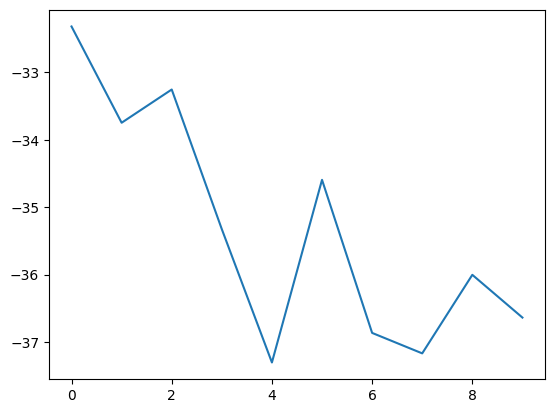

In [16]:
plt.plot(koz_entropy)

## Recursively compute marginal likelihood

## Debugged version to fix entropy

In [4]:
import torch
import torch.nn as nn
import numpy as np
from scipy.special import logsumexp
import pickle

# Assuming device is defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to encode preferences and compute Phi_tau_i, Phi_tau_j
def encode_preferences(encoder, preferences, segments):
    # Ensure encoder is frozen
    for param in encoder.parameters():
        param.requires_grad = False
    
    # Precompute Phi_tau (sum of embeddings over each trajectory)
    segment_states = [
        torch.tensor(
            np.array([state_t[0, 0, :] for state_t, _, _, done_t in segment if not done_t]),
            dtype=torch.float32
        ).to(device) if any(not done_t for _, _, _, done_t in segment) else None
        for segment in segments
    ]
    Phi_tau_list = []
    for seg_states in segment_states:
        if seg_states is not None:
            with torch.no_grad():
                phi, _, _ = encoder(seg_states)  # Shape: (T, feature_dim)
            Phi_tau = phi.sum(dim=0)  # Sum over trajectory: Shape: (feature_dim,)
            Phi_tau_list.append(Phi_tau)
        else:
            Phi_tau_list.append(None)
    
    # Precompute Phi_tau_i and Phi_tau_j tensors for valid preference pairs
    valid_pairs = [(i, j) for i, j, _ in preferences if Phi_tau_list[i] is not None and Phi_tau_list[j] is not None]
    if not valid_pairs:
        raise ValueError("No valid preference pairs found after filtering None values.")
    
    Phi_tau_i = torch.stack([Phi_tau_list[i] for i, j in valid_pairs])  # Shape: (num_valid_pairs, feature_dim)
    Phi_tau_j = torch.stack([Phi_tau_list[j] for i, j in valid_pairs])  # Shape: (num_valid_pairs, feature_dim)
    
    return Phi_tau_i, Phi_tau_j


## Replace the following with iteration
# Vectorized log likelihood for a batch of weights
def log_likelihood_vectorized(w_batch, Phi_tau_i, Phi_tau_j, beta):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)  # Shape: (n_samples, feature_dim)
    R_i = torch.matmul(Phi_tau_i, w_batch.T)  # Shape: (num_pairs, n_samples)
    R_j = torch.matmul(Phi_tau_j, w_batch.T)  # Shape: (num_pairs, n_samples)
    
    # Numerically stable computation
    beta_R_i = beta * R_i
    beta_R_j = beta * R_j
    
    
    terms = beta * R_j - torch.log(torch.exp(beta * R_i) + torch.exp(beta * R_j))
    
    # max_val = torch.maximum(beta_R_i, beta_R_j)
    # log_sum_exp = max_val + torch.log(
    #     torch.exp(beta_R_i - max_val) + torch.exp(beta_R_j - max_val)
    # )
    
    #terms = beta * R_j - log_sum_exp
    log_likelihoods = torch.sum(terms, dim=0)  # Shape: (n_samples,)
    return log_likelihoods.cpu().numpy()

# Compute entropy using importance sampling with recursive marginal likelihood
def compute_entropy_importance_sampling(Phi_tau_i, Phi_tau_j, samples, beta, log_P_H_cumulative):
    # Compute log likelihoods for all samples
    log_probs = log_likelihood_vectorized(samples, Phi_tau_i, Phi_tau_j, beta)
    
    if np.any(np.isnan(log_probs)) or np.any(np.isinf(log_probs)):
        raise ValueError("Log probabilities contain NaN or Inf values.")
    
    # First term: - (1 / m) * sum(log P(D, P | w^{(k)}))
    first_term = -np.mean(log_probs)
    print(f"First term: {first_term:.4f}")
    
    # Use the recursively estimated log P(H_{1:i}) instead of Harmonic Mean Estimator
    entropy = first_term + log_P_H_cumulative
    return entropy, log_probs

# MCMC for Bayesian REX with parallelized log_likelihood, MAP tracking, and weight normalization
def bayesian_rex_mcmc(trex_model, Phi_tau_i, Phi_tau_j, num_samples=10000, burn_in=1000, beta=1.0, proposal_std=0.005):
    w_current = trex_model.model.weight.data.clone().squeeze().to(device)
    w_current = w_current / torch.norm(w_current, p=2)
    
    def log_prior(w):
        return -0.5 * torch.sum(w ** 2)
    
    def log_likelihood(w, Phi_tau_i, Phi_tau_j, beta):
        R_i = torch.matmul(Phi_tau_i, w)
        R_j = torch.matmul(Phi_tau_j, w)
        terms = beta * R_j - torch.log(torch.exp(beta * R_i) + torch.exp(beta * R_j))
        return torch.sum(terms)
    
    samples = []
    accepted = 0
    w_map = w_current.clone()
    log_posterior_map = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
    
    for step in range(num_samples + burn_in):
        w_proposed = w_current + torch.normal(mean=0, std=proposal_std, size=w_current.shape).to(device)
        w_proposed = w_proposed / torch.norm(w_proposed, p=2)
        
        log_posterior_current = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
        log_posterior_proposed = log_prior(w_proposed) + log_likelihood(w_proposed, Phi_tau_i, Phi_tau_j, beta)
        
        if log_posterior_proposed > log_posterior_map:
            w_map = w_proposed.clone()
            log_posterior_map = log_posterior_proposed
        
        log_alpha = log_posterior_proposed - log_posterior_current
        alpha = torch.exp(log_alpha)
        
        if torch.rand(1, device=device) < alpha:
            w_current = w_proposed
            accepted += 1
            if step >= burn_in:
                samples.append(w_current.cpu().detach().numpy())
        
        if step % 5000 == 0:
            acceptance_rate = accepted / (step + 1) if step > 0 else 0
            print(f"MCMC Step {step}, Acceptance Rate: {acceptance_rate:.4f}")
    
    # Thin samples to reduce autocorrelation
    thinning = 10
    samples = samples[::thinning]
    
    print(f"Final Acceptance Rate: {accepted / (num_samples + burn_in):.4f}")
    print(f"MAP Log Posterior: {log_posterior_map.item()}")
    
    samples = np.array(samples)
    return samples, w_map

# Main execution
if __name__ == "__main__":
    # Load feedback data
    feedback_path = 'ppo_merge-v0_1377.pkl'
    with open(feedback_path, 'rb') as file:
        feedback_data = pickle.load(file)
    
    segments = feedback_data['segments']
    preferences = feedback_data['preferences']

    # Shuffle the preferences list
    preferences = np.random.permutation(preferences).tolist()
    print("Preferences have been shuffled.")
    
    # Initialize models (assuming these classes are defined elsewhere)
    state_dim = 5
    feature_dim = 10
    encoder = FeatureEncoder(input_dim=state_dim, feature_dim=feature_dim)
    trex_model = TREXRewardPredictor(feature_dim=feature_dim)
    
    encoder.load_state_dict(torch.load("feature_encoder_pretrain.pth", map_location=device))
    trex_model.load_state_dict(torch.load("trex_model_finetune.pth", map_location=device))
    
    encoder = encoder.to(device)
    trex_model = trex_model.to(device)
    encoder.eval()
    trex_model.eval()
    
    print("Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'")
    
    # Generate prior samples
    n_prior_samples = 20000
    prior_samples = np.random.normal(0, 1, (n_prior_samples, feature_dim))
    prior_samples = prior_samples / np.linalg.norm(prior_samples, axis=1, keepdims=True)
    
    # Initialize variables
    log_P_H_cumulative = 0.0
    prev_pref_size = 0
    preference_sizes = range(1000, len(preferences) + 1000, 1000)
    entropies = []
    all_posterior_samples = []
    all_map_solutions = []
    beta = 1.0
    
    print("Running Bayesian REX MCMC with recursive marginal likelihood estimation...")
    for pref_size in preference_sizes:
        print(f"\nProcessing preferences 0:{pref_size}")
        
        # Encode full and new preference subsets
        Phi_tau_i_full, Phi_tau_j_full = encode_preferences(encoder, preferences[:pref_size], segments)
        Phi_tau_i_new, Phi_tau_j_new = (
            encode_preferences(encoder, preferences[prev_pref_size:pref_size], segments)
            if prev_pref_size > 0 else (Phi_tau_i_full, Phi_tau_j_full)
        )
        
        # Estimate log P(H_new | H_prev)
        if prev_pref_size == 0:
            log_probs = log_likelihood_vectorized(prior_samples, Phi_tau_i_new, Phi_tau_j_new, beta)
        else:
            prev_samples = all_posterior_samples[-1]
            log_probs = log_likelihood_vectorized(prev_samples, Phi_tau_i_new, Phi_tau_j_new, beta)
        
        log_P_H_new_given_prev = logsumexp(log_probs) - np.log(len(log_probs))
        log_P_H_cumulative += log_P_H_new_given_prev
        print(f"Log P(H_{prev_pref_size}:{pref_size} | H_0:{prev_pref_size}) = {log_P_H_new_given_prev:.4f}")
        print(f"Cumulative Log P(H_0:{pref_size}) = {log_P_H_cumulative:.4f}")
        
        # Adjust proposal_std and burn_in based on pref_size
        #proposal_std = 0.05 if pref_size <= 2000 else 0.01 if pref_size <= 5000 else 0.005
        proposal_std = 0.008
        #burn_in = 10000 if pref_size <= 2000 else 5000
        burn_in = 10000
        
        # Run MCMC
        posterior_samples, map_solution = bayesian_rex_mcmc(
            trex_model,
            Phi_tau_i_full,
            Phi_tau_j_full,
            num_samples=50000,
            burn_in=burn_in,
            beta=beta,
            proposal_std=proposal_std
        )
        
        # Compute entropy with recursive marginal likelihood
        entropy, log_probs = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H_cumulative
        )
        
        # Debug 1: Inspect Autocorrelation
        from numpy import correlate
        if len(posterior_samples) > 1:  # Ensure enough samples for autocorrelation
            autocorr = correlate(posterior_samples[:, 0], posterior_samples[:, 0], mode='full')
            autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+5] / autocorr[len(autocorr)//2]
            print(f"Autocorrelation for first dimension (lags 0-4): {autocorr}")
        else:
            print("Not enough samples to compute autocorrelation.")
        
        # Debug 2: Validate Posterior Concentration
        sample_variance = np.var(posterior_samples, axis=0)
        print(f"Sample variance: {sample_variance}")
        
        # Debug 3: Cross-Check with MAP
        log_likelihood_map = log_likelihood_vectorized(map_solution.reshape(1, -1), Phi_tau_i_full, Phi_tau_j_full, beta)
        print(f"Log likelihood at MAP: {log_likelihood_map[0]:.4f}")
        print(f"Average log likelihood from samples: {-np.mean(log_probs):.4f}")
        
        # Store results
        entropies.append(entropy)
        all_posterior_samples.append(posterior_samples)
        all_map_solutions.append(map_solution)
        
        print(f"Entropy with {pref_size} preferences: {entropy:.4f}")
        prev_pref_size = pref_size
    
    # Save results with safeguard for tensors
    np.save("entropies.npy", np.array(entropies))
    for i, pref_size in enumerate(preference_sizes):
        np.save(f"posterior_samples_{pref_size}.npy", all_posterior_samples[i])
        # Ensure map_solution is a NumPy array
        map_solution = all_map_solutions[i]
        if isinstance(map_solution, torch.Tensor):
            map_solution = map_solution.cpu().detach().numpy()
        np.save(f"map_solution_{pref_size}.npy", map_solution)

    print("\nSummary of Entropies:")
    for pref_size, entropy in zip(preference_sizes, entropies):
        print(f"Preferences 0:{pref_size}: Entropy = {entropy:.4f}")

    print("Results saved: entropies.npy, posterior_samples_*.npy, map_solution_*.npy")

Preferences have been shuffled.
Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'
Running Bayesian REX MCMC with recursive marginal likelihood estimation...

Processing preferences 0:1000
Log P(H_0:1000 | H_0:0) = -1200.9311
Cumulative Log P(H_0:1000) = -1200.9311
MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.4487
MCMC Step 10000, Acceptance Rate: 0.4510
MCMC Step 15000, Acceptance Rate: 0.4524
MCMC Step 20000, Acceptance Rate: 0.4517
MCMC Step 25000, Acceptance Rate: 0.4528
MCMC Step 30000, Acceptance Rate: 0.4532
MCMC Step 35000, Acceptance Rate: 0.4529
MCMC Step 40000, Acceptance Rate: 0.4523
MCMC Step 45000, Acceptance Rate: 0.4514
MCMC Step 50000, Acceptance Rate: 0.4515
MCMC Step 55000, Acceptance Rate: 0.4506
Final Acceptance Rate: 0.4500
MAP Log Posterior: -883.9136962890625
First term: 887.6669
Autocorrelation for first dimension (lags 0-4): [1.         0.6210293  0.5223943  0.4931558  0.48356837]
Sample variance: [2.4199

/tmp/ipykernel_1219412/2709741545.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)  # Shape: (n_samples, feature_dim)


Log P(H_1000:2000 | H_0:1000) = -1036.4537
Cumulative Log P(H_0:2000) = -2237.3848
MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.3207
MCMC Step 10000, Acceptance Rate: 0.3111
MCMC Step 15000, Acceptance Rate: 0.3123
MCMC Step 20000, Acceptance Rate: 0.3122
MCMC Step 25000, Acceptance Rate: 0.3111
MCMC Step 30000, Acceptance Rate: 0.3106
MCMC Step 35000, Acceptance Rate: 0.3111
MCMC Step 40000, Acceptance Rate: 0.3101
MCMC Step 45000, Acceptance Rate: 0.3099
MCMC Step 50000, Acceptance Rate: 0.3087
MCMC Step 55000, Acceptance Rate: 0.3088
Final Acceptance Rate: 0.3085
MAP Log Posterior: -1978.475830078125
First term: 1982.3916
Autocorrelation for first dimension (lags 0-4): [1.         0.9385199  0.93413925 0.93214196 0.93313307]
Sample variance: [1.34499700e-04 1.04408056e-04 1.14056593e-05 1.31719949e-04
 1.32323607e-04 1.32566522e-04 1.32785994e-04 1.27647319e-04
 1.29746346e-04 1.39438227e-04]
Log likelihood at MAP: -1977.9758
Average log likelihood from sa

## Visualize the entropy with moving average

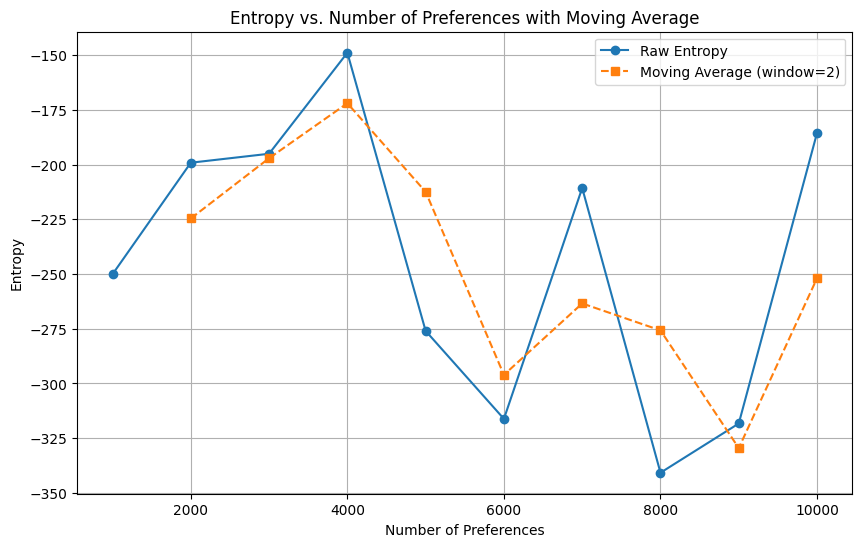


Summary of Entropies:
Preferences 0:1000: Entropy = -250.1023
Preferences 0:2000: Entropy = -199.1307
Preferences 0:3000: Entropy = -195.0399
Preferences 0:4000: Entropy = -148.8725
Preferences 0:5000: Entropy = -275.9835
Preferences 0:6000: Entropy = -316.1736
Preferences 0:7000: Entropy = -210.6894
Preferences 0:8000: Entropy = -340.7805
Preferences 0:9000: Entropy = -318.2854
Preferences 0:10000: Entropy = -185.5123
Results saved: entropies.npy, posterior_samples_*.npy, map_solution_*.npy
Plot saved: entropy_moving_average.png


In [5]:
import torch
import torch.nn as nn
import numpy as np
from scipy.special import logsumexp
import pickle
import matplotlib.pyplot as plt  # Added for visualization

# Assuming device is defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# [Previous functions: encode_preferences, log_likelihood_vectorized, compute_entropy_importance_sampling, bayesian_rex_mcmc]
# These remain unchanged from your provided code. For brevity, I'll only show the main execution loop with visualization.

# Function to compute moving average
def moving_average(data, window_size):
    """Compute the moving average of a 1D array with a given window size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Compute moving average of entropies
window_size = 2  # Adjust as needed (e.g., 3, 5)
if len(entropies) >= window_size:
    moving_avg_entropies = moving_average(np.array(entropies), window_size)
    # Adjust preference sizes for moving average (shorter due to convolution)
    moving_avg_pref_sizes = preference_sizes[window_size-1:]
else:
    print(f"Warning: Not enough entropy values ({len(entropies)}) for moving average with window size {window_size}")
    moving_avg_entropies = []
    moving_avg_pref_sizes = []

# Visualize entropy and moving average
plt.figure(figsize=(10, 6))
plt.plot(preference_sizes, entropies, label='Raw Entropy', marker='o', linestyle='-')
if len(moving_avg_entropies) > 0:
    plt.plot(moving_avg_pref_sizes, moving_avg_entropies, label=f'Moving Average (window={window_size})', marker='s', linestyle='--')
plt.xlabel('Number of Preferences')
plt.ylabel('Entropy')
plt.title('Entropy vs. Number of Preferences with Moving Average')
plt.legend()
plt.grid(True)
plt.savefig('entropy_moving_average.png')
plt.show()

print("\nSummary of Entropies:")
for pref_size, entropy in zip(preference_sizes, entropies):
    print(f"Preferences 0:{pref_size}: Entropy = {entropy:.4f}")

print("Results saved: entropies.npy, posterior_samples_*.npy, map_solution_*.npy")
print("Plot saved: entropy_moving_average.png")

In [ ]:
entropies

## Bridge sampling

In [3]:
import torch
import torch.nn as nn
import numpy as np
from scipy.special import logsumexp
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def encode_preferences(encoder, preferences, segments):
    for param in encoder.parameters():
        param.requires_grad = False
    
    segment_states = [
        torch.tensor(
            np.array([state_t[0, 0, :] for state_t, _, _, done_t in segment if not done_t]),
            dtype=torch.float32
        ).to(device) if any(not done_t for _, _, _, done_t in segment) else None
        for segment in segments
    ]
    Phi_tau_list = []
    for seg_states in segment_states:
        if seg_states is not None:
            with torch.no_grad():
                phi, _, _ = encoder(seg_states)
            Phi_tau = phi.sum(dim=0)
            Phi_tau_list.append(Phi_tau)
        else:
            Phi_tau_list.append(None)
    
    valid_pairs = [(i, j) for i, j, _ in preferences if Phi_tau_list[i] is not None and Phi_tau_list[j] is not None]
    if not valid_pairs:
        raise ValueError("No valid preference pairs found.")
    
    Phi_tau_i = torch.stack([Phi_tau_list[i] for i, j in valid_pairs])
    Phi_tau_j = torch.stack([Phi_tau_list[j] for i, j in valid_pairs])
    return Phi_tau_i, Phi_tau_j

def log_likelihood_vectorized(w_batch, Phi_tau_i, Phi_tau_j, beta):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    R_i = torch.matmul(Phi_tau_i, w_batch.T)
    R_j = torch.matmul(Phi_tau_j, w_batch.T)
    
    beta_R_i = beta * R_i
    beta_R_j = beta * R_j
    max_val = torch.maximum(beta_R_i, beta_R_j)
    log_sum_exp = max_val + torch.log(
        torch.exp(beta_R_i - max_val) + torch.exp(beta_R_j - max_val)
    )
    
    terms = beta * R_j - log_sum_exp
    log_likelihoods = torch.sum(terms, dim=0)
    
    if torch.any(log_likelihoods > 0):
        print("Warning: Positive log likelihood detected.")
        print(f"Sample terms: {terms[:5, :5]}")
        print(f"Log likelihoods: {log_likelihoods[:5]}")
    
    return log_likelihoods.cpu().numpy()

def log_prior_vectorized(w_batch):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    return -0.5 * torch.sum(w_batch ** 2, dim=1).cpu().numpy()

def bridge_sampling_marginal_likelihood(posterior_samples, prior_samples, Phi_tau_i, Phi_tau_j, beta):
    # Subsample to ensure equal sample sizes for simplicity
    n_samples = min(len(posterior_samples), len(prior_samples))
    posterior_samples = posterior_samples[np.random.choice(len(posterior_samples), n_samples, replace=False)]
    prior_samples = prior_samples[np.random.choice(len(prior_samples), n_samples, replace=False)]

    # Compute unnormalized posterior for posterior samples: log P(D, P | w) + log P(w)
    post_log_likelihoods = log_likelihood_vectorized(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    post_log_priors = log_prior_vectorized(posterior_samples)
    post_log_unnorm = post_log_likelihoods + post_log_priors  # log P(D, P | w) P(w)

    # Compute unnormalized posterior for prior samples
    prior_log_likelihoods = log_likelihood_vectorized(prior_samples, Phi_tau_i, Phi_tau_j, beta)
    prior_log_priors = log_prior_vectorized(prior_samples)
    prior_log_unnorm = prior_log_likelihoods + prior_log_priors

    # Normalize posterior (approximate log P(D, P))
    log_Z_approx = logsumexp(post_log_unnorm) - np.log(n_samples)

    # Bridge sampling with a simple mixture h(w) = alpha * P(w) + (1-alpha) * P(w | D, P)
    alpha = 0.5
    # Compute log h(w) for posterior samples
    log_h_post = logsumexp([
        np.log(alpha) + post_log_priors,
        np.log(1 - alpha) + post_log_unnorm - log_Z_approx
    ], axis=0)

    # Compute log h(w) for prior samples
    log_h_prior = logsumexp([
        np.log(alpha) + prior_log_priors,
        np.log(1 - alpha) + prior_log_unnorm - log_Z_approx
    ], axis=0)

    # Numerator: E_h [ P(w | D, P) / h(w) ]
    num_terms = (post_log_unnorm - log_Z_approx) - log_h_post
    numerator = logsumexp(num_terms) - np.log(n_samples)

    # Denominator: E_h [ P(D, P | w) P(w) / h(w) ]
    denom_terms = prior_log_unnorm - log_h_prior
    denominator = logsumexp(denom_terms) - np.log(n_samples)

    log_marginal = numerator - denominator
    return log_marginal

def compute_entropy_importance_sampling(Phi_tau_i, Phi_tau_j, samples, beta, log_P_H):
    log_probs = log_likelihood_vectorized(samples, Phi_tau_i, Phi_tau_j, beta)
    if np.any(np.isnan(log_probs)) or np.any(np.isinf(log_probs)):
        raise ValueError("Log probabilities contain NaN or Inf values.")
    
    log_prior_probs = log_prior_vectorized(samples)
    first_term = -np.mean(log_probs)
    prior_term = -np.mean(log_prior_probs)
    print(f"First term: {first_term:.4f}")
    print(f"Prior term: {prior_term:.4f}")
    
    entropy = first_term + prior_term + log_P_H
    return entropy, log_probs

def bayesian_rex_mcmc(trex_model, Phi_tau_i, Phi_tau_j, num_samples=10000, burn_in=1000, beta=1.0, proposal_std=0.005):
    w_current = trex_model.model.weight.data.clone().squeeze().to(device)
    w_current = w_current / torch.norm(w_current, p=2)
    
    def log_prior(w):
        return -0.5 * torch.sum(w ** 2)
    
    def log_likelihood(w, Phi_tau_i, Phi_tau_j, beta):
        R_i = torch.matmul(Phi_tau_i, w)
        R_j = torch.matmul(Phi_tau_j, w)
        terms = beta * R_j - torch.log(torch.exp(beta * R_i) + torch.exp(beta * R_j))
        return torch.sum(terms)
    
    samples = []
    accepted = 0
    w_map = w_current.clone()
    log_posterior_map = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
    
    for step in range(num_samples + burn_in):
        w_proposed = w_current + torch.normal(mean=0, std=proposal_std, size=w_current.shape).to(device)
        w_proposed = w_proposed / torch.norm(w_proposed, p=2)
        
        log_posterior_current = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
        log_posterior_proposed = log_prior(w_proposed) + log_likelihood(w_proposed, Phi_tau_i, Phi_tau_j, beta)
        
        if log_posterior_proposed > log_posterior_map:
            w_map = w_proposed.clone()
            log_posterior_map = log_posterior_proposed
        
        log_alpha = log_posterior_proposed - log_posterior_current
        alpha = torch.exp(log_alpha)
        
        if torch.rand(1, device=device) < alpha:
            w_current = w_proposed
            accepted += 1
            if step >= burn_in:
                samples.append(w_current.cpu().detach().numpy())
        
        if step % 5000 == 0:
            acceptance_rate = accepted / (step + 1) if step > 0 else 0
            print(f"MCMC Step {step}, Acceptance Rate: {acceptance_rate:.4f}")
    
    thinning = 10
    samples = samples[::thinning]
    
    print(f"Final Acceptance Rate: {accepted / (num_samples + burn_in):.4f}")
    print(f"MAP Log Posterior: {log_posterior_map.item()}")
    
    samples = np.array(samples)
    return samples, w_map

if __name__ == "__main__":
    feedback_path = 'ppo_merge-v0_1377.pkl'
    with open(feedback_path, 'rb') as file:
        feedback_data = pickle.load(file)
    
    segments = feedback_data['segments']
    preferences = feedback_data['preferences']
    preferences = np.random.permutation(preferences).tolist()
    print("Preferences have been shuffled.")
    
    state_dim = 5
    feature_dim = 10
    encoder = FeatureEncoder(input_dim=state_dim, feature_dim=feature_dim)
    trex_model = TREXRewardPredictor(feature_dim=feature_dim)
    
    encoder.load_state_dict(torch.load("feature_encoder_pretrain.pth", map_location=device))
    trex_model.load_state_dict(torch.load("trex_model_finetune.pth", map_location=device))
    
    encoder = encoder.to(device)
    trex_model = trex_model.to(device)
    encoder.eval()
    trex_model.eval()
    
    print("Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'")
    
    n_prior_samples = 20000
    prior_samples = np.random.normal(0, 1, (n_prior_samples, feature_dim))
    prior_samples = prior_samples / np.linalg.norm(prior_samples, axis=1, keepdims=True)
    
    preference_sizes = range(1000, len(preferences) + 1000, 1000)
    entropies = []
    all_posterior_samples = []
    all_map_solutions = []
    beta = 1.0
    
    print("Running Bayesian REX MCMC with bridge sampling for marginal likelihood...")
    for pref_size in preference_sizes:
        print(f"\nProcessing preferences 0:{pref_size}")
        
        Phi_tau_i_full, Phi_tau_j_full = encode_preferences(encoder, preferences[:pref_size], segments)
        
        proposal_std = 0.008
        burn_in = 10000
        
        posterior_samples, map_solution = bayesian_rex_mcmc(
            trex_model,
            Phi_tau_i_full,
            Phi_tau_j_full,
            num_samples=50000,
            burn_in=burn_in,
            beta=beta,
            proposal_std=proposal_std
        )
        
        # Estimate marginal likelihood using bridge sampling
        log_P_H = bridge_sampling_marginal_likelihood(
            posterior_samples, prior_samples, Phi_tau_i_full, Phi_tau_j_full, beta
        )
        print(f"Log P(H_0:{pref_size}) via Bridge Sampling = {log_P_H:.4f}")
        
        entropy, log_probs = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H
        )
        
        from numpy import correlate
        if len(posterior_samples) > 1:
            autocorr = correlate(posterior_samples[:, 0], posterior_samples[:, 0], mode='full')
            autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+5] / autocorr[len(autocorr)//2]
            print(f"Autocorrelation for first dimension (lags 0-4): {autocorr}")
        else:
            print("Not enough samples to compute autocorrelation.")
        
        sample_variance = np.var(posterior_samples, axis=0)
        print(f"Sample variance: {sample_variance}")
        
        log_likelihood_map = log_likelihood_vectorized(map_solution.reshape(1, -1), Phi_tau_i_full, Phi_tau_j_full, beta)
        print(f"Log likelihood at MAP: {log_likelihood_map[0]:.4f}")
        print(f"Average log likelihood from samples: {-np.mean(log_probs):.4f}")
        
        entropies.append(entropy)
        all_posterior_samples.append(posterior_samples)
        all_map_solutions.append(map_solution)
        
        print(f"Entropy with {pref_size} preferences: {entropy:.4f}")
    
    np.save("entropies.npy", np.array(entropies))
    for i, pref_size in enumerate(preference_sizes):
        np.save(f"posterior_samples_{pref_size}.npy", all_posterior_samples[i])
        map_solution = all_map_solutions[i]
        if isinstance(map_solution, torch.Tensor):
            map_solution = map_solution.cpu().detach().numpy()
        np.save(f"map_solution_{pref_size}.npy", map_solution)

    print("\nSummary of Entropies:")
    for pref_size, entropy in zip(preference_sizes, entropies):
        print(f"Preferences 0:{pref_size}: Entropy = {entropy:.4f}")

    print("Results saved: entropies.npy, posterior_samples_*.npy, map_solution_*.npy")

Preferences have been shuffled.
Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'
Running Bayesian REX MCMC with bridge sampling for marginal likelihood...

Processing preferences 0:1000
MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.4889
MCMC Step 10000, Acceptance Rate: 0.4852
MCMC Step 15000, Acceptance Rate: 0.4812
MCMC Step 20000, Acceptance Rate: 0.4808
MCMC Step 25000, Acceptance Rate: 0.4837
MCMC Step 30000, Acceptance Rate: 0.4832
MCMC Step 35000, Acceptance Rate: 0.4834
MCMC Step 40000, Acceptance Rate: 0.4838
MCMC Step 45000, Acceptance Rate: 0.4851
MCMC Step 50000, Acceptance Rate: 0.4858
MCMC Step 55000, Acceptance Rate: 0.4863
Final Acceptance Rate: 0.4869
MAP Log Posterior: -951.3011474609375
Log P(H_0:1000) via Bridge Sampling = 1162.8144
First term: 955.1077
Prior term: 0.5000
Autocorrelation for first dimension (lags 0-4): [1.         0.90996933 0.87553173 0.86182785 0.8550508 ]
Sample variance: [3.1483494e-04 2.5

/tmp/ipykernel_1267509/2075311122.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)


MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.3055
MCMC Step 10000, Acceptance Rate: 0.3000
MCMC Step 15000, Acceptance Rate: 0.2943
MCMC Step 20000, Acceptance Rate: 0.2940
MCMC Step 25000, Acceptance Rate: 0.2928
MCMC Step 30000, Acceptance Rate: 0.2924
MCMC Step 35000, Acceptance Rate: 0.2922
MCMC Step 40000, Acceptance Rate: 0.2921
MCMC Step 45000, Acceptance Rate: 0.2929
MCMC Step 50000, Acceptance Rate: 0.2934
MCMC Step 55000, Acceptance Rate: 0.2938
Final Acceptance Rate: 0.2942
MAP Log Posterior: -1882.8275146484375
Log P(H_0:2000) via Bridge Sampling = 2768.2741
First term: 1886.6631
Prior term: 0.5000
Autocorrelation for first dimension (lags 0-4): [1.         0.25736982 0.18138382 0.19003743 0.15887256]
Sample variance: [1.27096078e-04 1.04603205e-04 1.09074545e-05 1.44889462e-04
 1.31195338e-04 1.32741116e-04 1.22819125e-04 1.16492229e-04
 1.31236360e-04 1.22533354e-04]
Log likelihood at MAP: -1882.3276
Average log likelihood from samples: 1886.663

KeyboardInterrupt: 

In [7]:
entropies

[2355.7934226989746,
 4797.456374645233,
 7370.742642402649,
 8867.904938697815,
 13352.862210273743,
 14984.11238861084,
 17721.714725971222,
 20553.741911888123,
 20317.327649593353,
 25822.959520816803]

## Harmonic Mean Method

In [4]:
import torch
import torch.nn as nn
import numpy as np
from scipy.special import logsumexp
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def encode_preferences(encoder, preferences, segments):
    for param in encoder.parameters():
        param.requires_grad = False
    
    segment_states = [
        torch.tensor(
            np.array([state_t[0, 0, :] for state_t, _, _, done_t in segment if not done_t]),
            dtype=torch.float32
        ).to(device) if any(not done_t for _, _, _, done_t in segment) else None
        for segment in segments
    ]
    Phi_tau_list = []
    for seg_states in segment_states:
        if seg_states is not None:
            with torch.no_grad():
                phi, _, _ = encoder(seg_states)
            Phi_tau = phi.sum(dim=0)
            Phi_tau_list.append(Phi_tau)
        else:
            Phi_tau_list.append(None)
    
    valid_pairs = [(i, j) for i, j, _ in preferences if Phi_tau_list[i] is not None and Phi_tau_list[j] is not None]
    if not valid_pairs:
        raise ValueError("No valid preference pairs found.")
    
    Phi_tau_i = torch.stack([Phi_tau_list[i] for i, j in valid_pairs])
    Phi_tau_j = torch.stack([Phi_tau_list[j] for i, j in valid_pairs])
    return Phi_tau_i, Phi_tau_j

def log_likelihood_vectorized(w_batch, Phi_tau_i, Phi_tau_j, beta):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    R_i = torch.matmul(Phi_tau_i, w_batch.T)
    R_j = torch.matmul(Phi_tau_j, w_batch.T)
    
    beta_R_i = beta * R_i
    beta_R_j = beta * R_j
    max_val = torch.maximum(beta_R_i, beta_R_j)
    log_sum_exp = max_val + torch.log(
        torch.exp(beta_R_i - max_val) + torch.exp(beta_R_j - max_val)
    )
    
    terms = beta * R_j - log_sum_exp
    log_likelihoods = torch.sum(terms, dim=0)
    
    if torch.any(log_likelihoods > 0):
        print("Warning: Positive log likelihood detected.")
        print(f"Sample terms: {terms[:5, :5]}")
        print(f"Log likelihoods: {log_likelihoods[:5]}")
    
    return log_likelihoods.cpu().numpy()

def log_prior_vectorized(w_batch):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    return -0.5 * torch.sum(w_batch ** 2, dim=1).cpu().numpy()

def harmonic_mean_marginal_likelihood(posterior_samples, Phi_tau_i, Phi_tau_j, beta):
    # Compute log likelihood and log prior for posterior samples
    log_likelihoods = log_likelihood_vectorized(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    log_priors = log_prior_vectorized(posterior_samples)
    
    # Compute log P(D, P | w) P(w)
    log_unnorm = log_likelihoods + log_priors
    
    # Harmonic mean estimator: 1/P(D, P) = E[1/(P(D, P | w) P(w))]
    inverse_terms = -log_unnorm  # Since log(1/x) = -log(x)
    log_inverse_sum = logsumexp(inverse_terms) - np.log(len(posterior_samples))
    
    # log P(D, P) = -log(E[1/(P(D, P | w) P(w))])
    log_marginal = -log_inverse_sum
    return log_marginal

def bridge_sampling_marginal_likelihood(posterior_samples, prior_samples, Phi_tau_i, Phi_tau_j, beta):
    # Subsample to ensure equal sample sizes for simplicity
    n_samples = min(len(posterior_samples), len(prior_samples))
    posterior_samples = posterior_samples[np.random.choice(len(posterior_samples), n_samples, replace=False)]
    prior_samples = prior_samples[np.random.choice(len(prior_samples), n_samples, replace=False)]

    # Compute unnormalized posterior for posterior samples: log P(D, P | w) + log P(w)
    post_log_likelihoods = log_likelihood_vectorized(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    post_log_priors = log_prior_vectorized(posterior_samples)
    post_log_unnorm = post_log_likelihoods + post_log_priors

    # Compute unnormalized posterior for prior samples
    prior_log_likelihoods = log_likelihood_vectorized(prior_samples, Phi_tau_i, Phi_tau_j, beta)
    prior_log_priors = log_prior_vectorized(prior_samples)
    prior_log_unnorm = prior_log_likelihoods + prior_log_priors

    # Normalize posterior (approximate log P(D, P))
    log_Z_approx = logsumexp(post_log_unnorm) - np.log(n_samples)

    # Bridge sampling with a simple mixture h(w) = alpha * P(w) + (1-alpha) * P(w | D, P)
    alpha = 0.5
    log_h_post = logsumexp([
        np.log(alpha) + post_log_priors,
        np.log(1 - alpha) + post_log_unnorm - log_Z_approx
    ], axis=0)

    log_h_prior = logsumexp([
        np.log(alpha) + prior_log_priors,
        np.log(1 - alpha) + prior_log_unnorm - log_Z_approx
    ], axis=0)

    num_terms = (post_log_unnorm - log_Z_approx) - log_h_post
    numerator = logsumexp(num_terms) - np.log(n_samples)

    denom_terms = prior_log_unnorm - log_h_prior
    denominator = logsumexp(denom_terms) - np.log(n_samples)

    log_marginal = numerator - denominator
    return log_marginal

def compute_entropy_importance_sampling(Phi_tau_i, Phi_tau_j, samples, beta, log_P_H):
    log_probs = log_likelihood_vectorized(samples, Phi_tau_i, Phi_tau_j, beta)
    if np.any(np.isnan(log_probs)) or np.any(np.isinf(log_probs)):
        raise ValueError("Log probabilities contain NaN or Inf values.")
    
    log_prior_probs = log_prior_vectorized(samples)
    first_term = -np.mean(log_probs)
    prior_term = -np.mean(log_prior_probs)
    print(f"First term: {first_term:.4f}")
    print(f"Prior term: {prior_term:.4f}")
    
    entropy = first_term + prior_term + log_P_H
    return entropy, log_probs

def bayesian_rex_mcmc(trex_model, Phi_tau_i, Phi_tau_j, num_samples=10000, burn_in=1000, beta=1.0, proposal_std=0.005):
    w_current = trex_model.model.weight.data.clone().squeeze().to(device)
    w_current = w_current / torch.norm(w_current, p=2)
    
    def log_prior(w):
        return -0.5 * torch.sum(w ** 2)
    
    def log_likelihood(w, Phi_tau_i, Phi_tau_j, beta):
        R_i = torch.matmul(Phi_tau_i, w)
        R_j = torch.matmul(Phi_tau_j, w)
        terms = beta * R_j - torch.log(torch.exp(beta * R_i) + torch.exp(beta * R_j))
        return torch.sum(terms)
    
    samples = []
    accepted = 0
    w_map = w_current.clone()
    log_posterior_map = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
    
    for step in range(num_samples + burn_in):
        w_proposed = w_current + torch.normal(mean=0, std=proposal_std, size=w_current.shape).to(device)
        w_proposed = w_proposed / torch.norm(w_proposed, p=2)
        
        log_posterior_current = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
        log_posterior_proposed = log_prior(w_proposed) + log_likelihood(w_proposed, Phi_tau_i, Phi_tau_j, beta)
        
        if log_posterior_proposed > log_posterior_map:
            w_map = w_proposed.clone()
            log_posterior_map = log_posterior_proposed
        
        log_alpha = log_posterior_proposed - log_posterior_current
        alpha = torch.exp(log_alpha)
        
        if torch.rand(1, device=device) < alpha:
            w_current = w_proposed
            accepted += 1
            if step >= burn_in:
                samples.append(w_current.cpu().detach().numpy())
        
        if step % 5000 == 0:
            acceptance_rate = accepted / (step + 1) if step > 0 else 0
            print(f"MCMC Step {step}, Acceptance Rate: {acceptance_rate:.4f}")
    
    thinning = 10
    samples = samples[::thinning]
    
    print(f"Final Acceptance Rate: {accepted / (num_samples + burn_in):.4f}")
    print(f"MAP Log Posterior: {log_posterior_map.item()}")
    
    samples = np.array(samples)
    return samples, w_map

if __name__ == "__main__":
    feedback_path = 'ppo_merge-v0_1377.pkl'
    with open(feedback_path, 'rb') as file:
        feedback_data = pickle.load(file)
    
    segments = feedback_data['segments']
    preferences = feedback_data['preferences']
    preferences = np.random.permutation(preferences).tolist()
    print("Preferences have been shuffled.")
    
    state_dim = 5
    feature_dim = 10
    encoder = FeatureEncoder(input_dim=state_dim, feature_dim=feature_dim)
    trex_model = TREXRewardPredictor(feature_dim=feature_dim)
    
    encoder.load_state_dict(torch.load("feature_encoder_pretrain.pth", map_location=device))
    trex_model.load_state_dict(torch.load("trex_model_finetune.pth", map_location=device))
    
    encoder = encoder.to(device)
    trex_model = trex_model.to(device)
    encoder.eval()
    trex_model.eval()
    
    print("Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'")
    
    n_prior_samples = 20000
    prior_samples = np.random.normal(0, 1, (n_prior_samples, feature_dim))
    prior_samples = prior_samples / np.linalg.norm(prior_samples, axis=1, keepdims=True)
    
    preference_sizes = range(1000, len(preferences) + 1000, 1000)
    entropies_hm = []
    entropies_bridge = []
    all_posterior_samples = []
    all_map_solutions = []
    beta = 1.0
    
    print("Running Bayesian REX MCMC with harmonic mean and bridge sampling for marginal likelihood...")
    for pref_size in preference_sizes:
        print(f"\nProcessing preferences 0:{pref_size}")
        
        Phi_tau_i_full, Phi_tau_j_full = encode_preferences(encoder, preferences[:pref_size], segments)
        
        proposal_std = 0.008
        burn_in = 10000
        
        posterior_samples, map_solution = bayesian_rex_mcmc(
            trex_model,
            Phi_tau_i_full,
            Phi_tau_j_full,
            num_samples=50000,
            burn_in=burn_in,
            beta=beta,
            proposal_std=proposal_std
        )
        
        # Estimate marginal likelihood using harmonic mean
        log_P_H_hm = harmonic_mean_marginal_likelihood(
            posterior_samples, Phi_tau_i_full, Phi_tau_j_full, beta
        )
        print(f"Log P(H_0:{pref_size}) via Harmonic Mean = {log_P_H_hm:.4f}")
        
        # Estimate marginal likelihood using bridge sampling
        log_P_H_bridge = bridge_sampling_marginal_likelihood(
            posterior_samples, prior_samples, Phi_tau_i_full, Phi_tau_j_full, beta
        )
        print(f"Log P(H_0:{pref_size}) via Bridge Sampling = {log_P_H_bridge:.4f}")
        
        # Compute entropy using both estimates
        entropy_hm, log_probs = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H_hm
        )
        entropy_bridge, _ = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H_bridge
        )
        
        from numpy import correlate
        if len(posterior_samples) > 1:
            autocorr = correlate(posterior_samples[:, 0], posterior_samples[:, 0], mode='full')
            autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+5] / autocorr[len(autocorr)//2]
            print(f"Autocorrelation for first dimension (lags 0-4): {autocorr}")
        else:
            print("Not enough samples to compute autocorrelation.")
        
        sample_variance = np.var(posterior_samples, axis=0)
        print(f"Sample variance: {sample_variance}")
        
        log_likelihood_map = log_likelihood_vectorized(map_solution.reshape(1, -1), Phi_tau_i_full, Phi_tau_j_full, beta)
        print(f"Log likelihood at MAP: {log_likelihood_map[0]:.4f}")
        print(f"Average log likelihood from samples: {-np.mean(log_probs):.4f}")
        
        entropies_hm.append(entropy_hm)
        entropies_bridge.append(entropy_bridge)
        all_posterior_samples.append(posterior_samples)
        all_map_solutions.append(map_solution)
        
        print(f"Entropy with {pref_size} preferences (Harmonic Mean): {entropy_hm:.4f}")
        print(f"Entropy with {pref_size} preferences (Bridge Sampling): {entropy_bridge:.4f}")
    
    np.save("entropies_hm.npy", np.array(entropies_hm))
    np.save("entropies_bridge.npy", np.array(entropies_bridge))
    for i, pref_size in enumerate(preference_sizes):
        np.save(f"posterior_samples_{pref_size}.npy", all_posterior_samples[i])
        map_solution = all_map_solutions[i]
        if isinstance(map_solution, torch.Tensor):
            map_solution = map_solution.cpu().detach().numpy()
        np.save(f"map_solution_{pref_size}.npy", map_solution)

    print("\nSummary of Entropies:")
    for pref_size, entropy_hm, entropy_bridge in zip(preference_sizes, entropies_hm, entropies_bridge):
        print(f"Preferences 0:{pref_size}: Entropy (Harmonic Mean) = {entropy_hm:.4f}, (Bridge Sampling) = {entropy_bridge:.4f}")

    print("Results saved: entropies_hm.npy, entropies_bridge.npy, posterior_samples_*.npy, map_solution_*.npy")

Preferences have been shuffled.
Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'
Running Bayesian REX MCMC with harmonic mean and bridge sampling for marginal likelihood...

Processing preferences 0:1000
MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.4699
MCMC Step 10000, Acceptance Rate: 0.4685
MCMC Step 15000, Acceptance Rate: 0.4702
MCMC Step 20000, Acceptance Rate: 0.4691
MCMC Step 25000, Acceptance Rate: 0.4692
MCMC Step 30000, Acceptance Rate: 0.4676
MCMC Step 35000, Acceptance Rate: 0.4668
MCMC Step 40000, Acceptance Rate: 0.4652
MCMC Step 45000, Acceptance Rate: 0.4644
MCMC Step 50000, Acceptance Rate: 0.4644
MCMC Step 55000, Acceptance Rate: 0.4645
Final Acceptance Rate: 0.4644
MAP Log Posterior: -1004.2062377929688
Log P(H_0:1000) via Harmonic Mean = -1011.8469
Log P(H_0:1000) via Bridge Sampling = 1157.2259
First term: 1007.9698
Prior term: 0.5000
First term: 1007.9698
Prior term: 0.5000
Autocorrelation for first dimens

/tmp/ipykernel_1267509/1240284996.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)


MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.3187
MCMC Step 10000, Acceptance Rate: 0.3129
MCMC Step 15000, Acceptance Rate: 0.3097
MCMC Step 20000, Acceptance Rate: 0.3095
MCMC Step 25000, Acceptance Rate: 0.3076
MCMC Step 30000, Acceptance Rate: 0.3056
MCMC Step 35000, Acceptance Rate: 0.3046
MCMC Step 40000, Acceptance Rate: 0.3037
MCMC Step 45000, Acceptance Rate: 0.3050
MCMC Step 50000, Acceptance Rate: 0.3054
MCMC Step 55000, Acceptance Rate: 0.3051
Final Acceptance Rate: 0.3051
MAP Log Posterior: -1999.2215576171875
Log P(H_0:2000) via Harmonic Mean = -2007.7795
Log P(H_0:2000) via Bridge Sampling = 2761.0744
First term: 2003.1044
Prior term: 0.5000
First term: 2003.1044
Prior term: 0.5000
Autocorrelation for first dimension (lags 0-4): [1.         0.942019   0.93438756 0.9328645  0.9314358 ]
Sample variance: [1.2476741e-04 1.1029735e-04 1.0779206e-05 1.3718240e-04 1.2993690e-04
 1.4057408e-04 1.3762675e-04 1.2083919e-04 1.3601471e-04 1.3250746e-04]
Lo

## Debuged Bridge

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.special import logsumexp
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def encode_preferences(encoder, preferences, segments):
    for param in encoder.parameters():
        param.requires_grad = False
    
    segment_states = [
        torch.tensor(
            np.array([state_t[0, 0, :] for state_t, _, _, done_t in segment if not done_t]),
            dtype=torch.float32
        ).to(device) if any(not done_t for _, _, _, done_t in segment) else None
        for segment in segments
    ]
    Phi_tau_list = []
    for seg_states in segment_states:
        if seg_states is not None:
            with torch.no_grad():
                phi, _, _ = encoder(seg_states)
            Phi_tau = phi.sum(dim=0)
            Phi_tau_list.append(Phi_tau)
        else:
            Phi_tau_list.append(None)
    
    valid_pairs = [(i, j) for i, j, _ in preferences if Phi_tau_list[i] is not None and Phi_tau_list[j] is not None]
    if not valid_pairs:
        raise ValueError("No valid preference pairs found.")
    
    Phi_tau_i = torch.stack([Phi_tau_list[i] for i, j in valid_pairs])
    Phi_tau_j = torch.stack([Phi_tau_list[j] for i, j in valid_pairs])
    return Phi_tau_i, Phi_tau_j

def log_likelihood_vectorized(w_batch, Phi_tau_i, Phi_tau_j, beta):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    R_i = torch.matmul(Phi_tau_i, w_batch.T)
    R_j = torch.matmul(Phi_tau_j, w_batch.T)
    
    beta_R_i = beta * R_i
    beta_R_j = beta * R_j
    max_val = torch.maximum(beta_R_i, beta_R_j)
    log_sum_exp = max_val + torch.log(
        torch.exp(beta_R_i - max_val) + torch.exp(beta_R_j - max_val)
    )
    
    terms = beta * R_j - log_sum_exp
    log_likelihoods = torch.sum(terms, dim=0)
    
    if torch.any(log_likelihoods > 0):
        print("Warning: Positive log likelihood detected.")
        print(f"Sample terms: {terms[:5, :5]}")
        print(f"Log likelihoods: {log_likelihoods[:5]}")
    
    return log_likelihoods.cpu().numpy()

def log_prior_vectorized(w_batch):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    return -0.5 * torch.sum(w_batch ** 2, dim=1).cpu().numpy()

def harmonic_mean_marginal_likelihood(posterior_samples, Phi_tau_i, Phi_tau_j, beta):
    log_likelihoods = log_likelihood_vectorized(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    log_priors = log_prior_vectorized(posterior_samples)
    log_unnorm = log_likelihoods + log_priors
    inverse_terms = -log_unnorm
    log_inverse_sum = logsumexp(inverse_terms) - np.log(len(posterior_samples))
    log_marginal = -log_inverse_sum
    return log_marginal

def bridge_sampling_marginal_likelihood(posterior_samples, prior_samples, Phi_tau_i, Phi_tau_j, beta, max_iter=20, tol=1e-3):
    # Compute unnormalized posterior for posterior samples
    post_log_likelihoods = log_likelihood_vectorized(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    post_log_priors = log_prior_vectorized(posterior_samples)
    post_log_unnorm = post_log_likelihoods + post_log_priors

    # Compute unnormalized posterior for prior samples
    prior_log_likelihoods = log_likelihood_vectorized(prior_samples, Phi_tau_i, Phi_tau_j, beta)
    prior_log_priors = log_prior_vectorized(prior_samples)
    prior_log_unnorm = prior_log_likelihoods + prior_log_priors

    # Initial guess using harmonic mean for better starting point
    log_Z = harmonic_mean_marginal_likelihood(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    print(f"Initial log Z (harmonic mean): {log_Z:.4f}")

    # Iterative bridge sampling
    m_post = len(posterior_samples)
    m_prior = len(prior_samples)
    alpha = 0.5

    for iteration in range(max_iter):
        # Compute bridge function h(w) for posterior samples
        log_h_post = np.log(alpha / m_prior + (1 - alpha) / m_post) + logsumexp([
            np.log(alpha) + post_log_priors,
            np.log(1 - alpha) + post_log_unnorm - log_Z
        ], axis=0)

        # Compute bridge function h(w) for prior samples
        log_h_prior = np.log(alpha / m_prior + (1 - alpha) / m_post) + logsumexp([
            np.log(alpha) + prior_log_priors,
            np.log(1 - alpha) + prior_log_unnorm - log_Z
        ], axis=0)

        # Numerator: E_h [ P(w | D, P) / h(w) ]
        num_terms = (post_log_unnorm - log_Z) - log_h_post
        numerator = logsumexp(num_terms) - np.log(m_post)

        # Denominator: E_h [ P(D, P | w) P(w) / h(w) ]
        denom_terms = prior_log_unnorm - log_h_prior
        denominator = logsumexp(denom_terms) - np.log(m_prior)

        # Update log Z
        new_log_Z = numerator - denominator
        if abs(new_log_Z - log_Z) < tol:
            break
        log_Z = new_log_Z
        print(f"Iteration {iteration+1}, log Z = {log_Z:.4f}")

    if log_Z > 0:
        print("Warning: log P(D, P) is positive, which is incorrect. Check likelihood and prior computations.")
    return log_Z

def compute_entropy_importance_sampling(Phi_tau_i, Phi_tau_j, samples, beta, log_P_H):
    log_probs = log_likelihood_vectorized(samples, Phi_tau_i, Phi_tau_j, beta)
    if np.any(np.isnan(log_probs)) or np.any(np.isinf(log_probs)):
        raise ValueError("Log probabilities contain NaN or Inf values.")
    
    log_prior_probs = log_prior_vectorized(samples)
    first_term = -np.mean(log_probs)
    prior_term = -np.mean(log_prior_probs)
    print(f"First term: {first_term:.4f}")
    print(f"Prior term: {prior_term:.4f}")
    
    entropy = first_term + prior_term + log_P_H
    return entropy, log_probs

def bayesian_rex_mcmc(trex_model, Phi_tau_i, Phi_tau_j, num_samples=10000, burn_in=1000, beta=1.0, proposal_std=0.005):
    w_current = trex_model.model.weight.data.clone().squeeze().to(device)
    w_current = w_current / torch.norm(w_current, p=2)
    
    def log_prior(w):
        return -0.5 * torch.sum(w ** 2)
    
    def log_likelihood(w, Phi_tau_i, Phi_tau_j, beta):
        R_i = torch.matmul(Phi_tau_i, w)
        R_j = torch.matmul(Phi_tau_j, w)
        terms = beta * R_j - torch.log(torch.exp(beta * R_i) + torch.exp(beta * R_j))
        return torch.sum(terms)
    
    samples = []
    accepted = 0
    w_map = w_current.clone()
    log_posterior_map = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
    
    for step in range(num_samples + burn_in):
        w_proposed = w_current + torch.normal(mean=0, std=proposal_std, size=w_current.shape).to(device)
        w_proposed = w_proposed / torch.norm(w_proposed, p=2)
        
        log_posterior_current = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
        log_posterior_proposed = log_prior(w_proposed) + log_likelihood(w_proposed, Phi_tau_i, Phi_tau_j, beta)
        
        if log_posterior_proposed > log_posterior_map:
            w_map = w_proposed.clone()
            log_posterior_map = log_posterior_proposed
        
        log_alpha = log_posterior_proposed - log_posterior_current
        alpha = torch.exp(log_alpha)
        
        if torch.rand(1, device=device) < alpha:
            w_current = w_proposed
            accepted += 1
            if step >= burn_in:
                samples.append(w_current.cpu().detach().numpy())
        
        if step % 5000 == 0:
            acceptance_rate = accepted / (step + 1) if step > 0 else 0
            print(f"MCMC Step {step}, Acceptance Rate: {acceptance_rate:.4f}")
    
    thinning = 20
    samples = samples[::thinning]

    print(f"Final Acceptance Rate: {accepted / (num_samples + burn_in):.4f}")
    print(f"MAP Log Posterior: {log_posterior_map.item()}")
    
    samples = np.array(samples)
    return samples, w_map

if __name__ == "__main__":
    feedback_path = 'ppo_merge-v0_1377.pkl'
    with open(feedback_path, 'rb') as file:
        feedback_data = pickle.load(file)
    
    segments = feedback_data['segments']
    preferences = feedback_data['preferences']
    preferences = np.random.permutation(preferences).tolist()
    print("Preferences have been shuffled.")
    
    state_dim = 5
    feature_dim = 10
    encoder = FeatureEncoder(input_dim=state_dim, feature_dim=feature_dim)
    trex_model = TREXRewardPredictor(feature_dim=feature_dim)
    
    encoder.load_state_dict(torch.load("feature_encoder_pretrain.pth", map_location=device))
    trex_model.load_state_dict(torch.load("trex_model_finetune.pth", map_location=device))
    
    encoder = encoder.to(device)
    trex_model = trex_model.to(device)
    encoder.eval()
    trex_model.eval()

    print("Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'")

    n_prior_samples = 20000
    prior_samples = np.random.normal(0, 1, (n_prior_samples, feature_dim))
    prior_samples = prior_samples / np.linalg.norm(prior_samples, axis=1, keepdims=True)
    
    preference_sizes = range(1000, len(preferences) + 1000, 1000)
    entropies_hm = []
    entropies_bridge = []
    all_posterior_samples = []
    all_map_solutions = []
    beta = 1.0
    
    print("Running Bayesian REX MCMC with harmonic mean and corrected bridge sampling for marginal likelihood...")
    for pref_size in preference_sizes:
        print(f"\nProcessing preferences 0:{pref_size}")
        
        Phi_tau_i_full, Phi_tau_j_full = encode_preferences(encoder, preferences[:pref_size], segments)
        
        proposal_std = 0.008
        burn_in = 10000
        
        posterior_samples, map_solution = bayesian_rex_mcmc(
            trex_model,
            Phi_tau_i_full,
            Phi_tau_j_full,
            num_samples=50000,
            burn_in=burn_in,
            beta=beta,
            proposal_std=proposal_std
        )
        
        # Estimate marginal likelihood using harmonic mean
        log_P_H_hm = harmonic_mean_marginal_likelihood(
            posterior_samples, Phi_tau_i_full, Phi_tau_j_full, beta
        )
        print(f"Log P(H_0:{pref_size}) via Harmonic Mean = {log_P_H_hm:.4f}")
        
        # Estimate marginal likelihood using corrected bridge sampling
        log_P_H_bridge = bridge_sampling_marginal_likelihood(
            posterior_samples, prior_samples, Phi_tau_i_full, Phi_tau_j_full, beta
        )
        print(f"Log P(H_0:{pref_size}) via Bridge Sampling = {log_P_H_bridge:.4f}")
        
        # Compute entropy using both estimates
        entropy_hm, log_probs = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H_hm
        )
        entropy_bridge, _ = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H_bridge
        )
        
        from numpy import correlate
        if len(posterior_samples) > 1:
            autocorr = correlate(posterior_samples[:, 0], posterior_samples[:, 0], mode='full')
            autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+5] / autocorr[len(autocorr)//2]
            print(f"Autocorrelation for first dimension (lags 0-4): {autocorr}")
        else:
            print("Not enough samples to compute autocorrelation.")
        
        sample_variance = np.var(posterior_samples, axis=0)
        print(f"Sample variance: {sample_variance}")
        
        log_likelihood_map = log_likelihood_vectorized(map_solution.reshape(1, -1), Phi_tau_i_full, Phi_tau_j_full, beta)
        print(f"Log likelihood at MAP: {log_likelihood_map[0]:.4f}")
        print(f"Average log likelihood from samples: {-np.mean(log_probs):.4f}")
        
        entropies_hm.append(entropy_hm)
        entropies_bridge.append(entropy_bridge)
        all_posterior_samples.append(posterior_samples)
        all_map_solutions.append(map_solution)
        
        print(f"Entropy with {pref_size} preferences (Harmonic Mean): {entropy_hm:.4f}")
        print(f"Entropy with {pref_size} preferences (Bridge Sampling): {entropy_bridge:.4f}")
    
    np.save("entropies_hm.npy", np.array(entropies_hm))
    np.save("entropies_bridge.npy", np.array(entropies_bridge))
    for i, pref_size in enumerate(preference_sizes):
        np.save(f"posterior_samples_{pref_size}.npy", all_posterior_samples[i])
        map_solution = all_map_solutions[i]
        if isinstance(map_solution, torch.Tensor):
            map_solution = map_solution.cpu().detach().numpy()
        np.save(f"map_solution_{pref_size}.npy", map_solution)

    print("\nSummary of Entropies:")
    for pref_size, entropy_hm, entropy_bridge in zip(preference_sizes, entropies_hm, entropies_bridge):
        print(f"Preferences 0:{pref_size}: Entropy (Harmonic Mean) = {entropy_hm:.4f}, (Bridge Sampling) = {entropy_bridge:.4f}")

    print("Results saved: entropies_hm.npy, entropies_bridge.npy, posterior_samples_*.npy, map_solution_*.npy")

Preferences have been shuffled.
Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'
Running Bayesian REX MCMC with harmonic mean and corrected bridge sampling for marginal likelihood...

Processing preferences 0:1000
MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.4695
MCMC Step 10000, Acceptance Rate: 0.4618
MCMC Step 15000, Acceptance Rate: 0.4601
MCMC Step 20000, Acceptance Rate: 0.4595
MCMC Step 25000, Acceptance Rate: 0.4575
MCMC Step 30000, Acceptance Rate: 0.4588
MCMC Step 35000, Acceptance Rate: 0.4588
MCMC Step 40000, Acceptance Rate: 0.4573
MCMC Step 45000, Acceptance Rate: 0.4583
MCMC Step 50000, Acceptance Rate: 0.4578
MCMC Step 55000, Acceptance Rate: 0.4589
Final Acceptance Rate: 0.4591
MAP Log Posterior: -948.7210083007812
Log P(H_0:1000) via Harmonic Mean = -958.5094
Initial log Z (harmonic mean): -958.5094
Iteration 1, log Z = 1312.0614
Iteration 2, log Z = -951.0302
Iteration 3, log Z = 1310.9304
Iteration 4, log Z =

/tmp/ipykernel_1267509/3988585876.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)


MCMC Step 0, Acceptance Rate: 0.0000
MCMC Step 5000, Acceptance Rate: 0.3291
MCMC Step 10000, Acceptance Rate: 0.3186
MCMC Step 15000, Acceptance Rate: 0.3106
MCMC Step 20000, Acceptance Rate: 0.3078
MCMC Step 25000, Acceptance Rate: 0.3076
MCMC Step 30000, Acceptance Rate: 0.3100
MCMC Step 35000, Acceptance Rate: 0.3091
MCMC Step 40000, Acceptance Rate: 0.3089
MCMC Step 45000, Acceptance Rate: 0.3081
MCMC Step 50000, Acceptance Rate: 0.3076
MCMC Step 55000, Acceptance Rate: 0.3082
Final Acceptance Rate: 0.3090
MAP Log Posterior: -1967.9453125
Log P(H_0:2000) via Harmonic Mean = -1977.2734
Initial log Z (harmonic mean): -1977.2734
Iteration 1, log Z = 2694.2566
Iteration 2, log Z = -1970.3968
Iteration 3, log Z = 2693.1327
Iteration 4, log Z = -1969.2733
Iteration 5, log Z = 2692.5325
Iteration 6, log Z = -1968.6727
Iteration 7, log Z = 2692.1315
Iteration 8, log Z = -1968.2718
Iteration 9, log Z = 2691.8337
Iteration 10, log Z = -1967.9739
Iteration 11, log Z = 2691.5981
Iteration 12,

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.special import logsumexp
import pickle
from scipy.special import gammaln

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def encode_preferences(encoder, preferences, segments):
    for param in encoder.parameters():
        param.requires_grad = False
    
    segment_states = [
        torch.tensor(
            np.array([state_t[0, 0, :] for state_t, _, _, done_t in segment if not done_t]),
            dtype=torch.float32
        ).to(device) if any(not done_t for _, _, _, done_t in segment) else None
        for segment in segments
    ]
    Phi_tau_list = []
    for seg_states in segment_states:
        if seg_states is not None:
            with torch.no_grad():
                phi, _, _ = encoder(seg_states)
            Phi_tau = phi.sum(dim=0)
            Phi_tau_list.append(Phi_tau)
        else:
            Phi_tau_list.append(None)
    
    valid_pairs = [(i, j) for i, j, _ in preferences if Phi_tau_list[i] is not None and Phi_tau_list[j] is not None]
    if not valid_pairs:
        raise ValueError("No valid preference pairs found.")
    
    Phi_tau_i = torch.stack([Phi_tau_list[i] for i, j in valid_pairs])
    Phi_tau_j = torch.stack([Phi_tau_list[j] for i, j in valid_pairs])
    return Phi_tau_i, Phi_tau_j

def log_likelihood_vectorized(w_batch, Phi_tau_i, Phi_tau_j, beta):
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    R_i = torch.matmul(Phi_tau_i, w_batch.T)
    R_j = torch.matmul(Phi_tau_j, w_batch.T)
    
    beta_R_i = beta * R_i
    beta_R_j = beta * R_j
    max_val = torch.maximum(beta_R_i, beta_R_j)
    log_sum_exp = max_val + torch.log(
        torch.exp(beta_R_i - max_val) + torch.exp(beta_R_j - max_val)
    )
    
    terms = beta * R_j - log_sum_exp
    log_likelihoods = torch.sum(terms, dim=0)
    
    if torch.any(log_likelihoods > 0):
        print("Warning: Positive log likelihood detected.")
        print(f"Sample terms: {terms[:5, :5]}")
        print(f"Log likelihoods: {log_likelihoods[:5]}")
    
    return log_likelihoods.cpu().numpy()

def log_prior_vectorized(w_batch):
    # Uniform prior on the unit sphere (d-1 dimensions)
    # Log of the surface area of a (d-1)-sphere: log(2 * pi^(d/2) / Gamma(d/2))
    w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)
    d = w_batch.shape[1]  # feature_dim
    log_surface_area = np.log(2) + (d/2) * np.log(np.pi) - gammaln(d/2)
    return -log_surface_area * torch.ones(w_batch.shape[0]).to(device).cpu().numpy()

def harmonic_mean_marginal_likelihood(posterior_samples, Phi_tau_i, Phi_tau_j, beta):
    log_likelihoods = log_likelihood_vectorized(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    log_priors = log_prior_vectorized(posterior_samples)
    log_unnorm = log_likelihoods + log_priors
    inverse_terms = -log_unnorm
    log_inverse_sum = logsumexp(inverse_terms) - np.log(len(posterior_samples))
    log_marginal = -log_inverse_sum
    return log_marginal

def bridge_sampling_marginal_likelihood(posterior_samples, prior_samples, Phi_tau_i, Phi_tau_j, beta, max_iter=50, tol=1e-4):
    # Compute unnormalized posterior for posterior samples
    post_log_likelihoods = log_likelihood_vectorized(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    post_log_priors = log_prior_vectorized(posterior_samples)
    post_log_unnorm = post_log_likelihoods + post_log_priors

    # Compute unnormalized posterior for prior samples
    prior_log_likelihoods = log_likelihood_vectorized(prior_samples, Phi_tau_i, Phi_tau_j, beta)
    prior_log_priors = log_prior_vectorized(prior_samples)
    prior_log_unnorm = prior_log_likelihoods + prior_log_priors

    # Initial guess using harmonic mean
    log_Z = harmonic_mean_marginal_likelihood(posterior_samples, Phi_tau_i, Phi_tau_j, beta)
    print(f"Initial log Z (harmonic mean): {log_Z:.4f}")

    # Iterative bridge sampling with adjusted alpha
    m_post = len(posterior_samples)
    m_prior = len(prior_samples)
    alpha = m_post / (m_post + m_prior)  # Optimal alpha for balanced sampling

    for iteration in range(max_iter):
        # Compute bridge function h(w) for posterior samples
        log_h_post = np.log(alpha / m_prior + (1 - alpha) / m_post) + logsumexp([
            np.log(alpha) + post_log_priors,
            np.log(1 - alpha) + post_log_unnorm - log_Z
        ], axis=0)

        # Compute bridge function h(w) for prior samples
        log_h_prior = np.log(alpha / m_prior + (1 - alpha) / m_post) + logsumexp([
            np.log(alpha) + prior_log_priors,
            np.log(1 - alpha) + prior_log_unnorm - log_Z
        ], axis=0)

        # Numerator: E_h [ P(w | D, P) / h(w) ]
        num_terms = (post_log_unnorm - log_Z) - log_h_post
        numerator = logsumexp(num_terms) - np.log(m_post)

        # Denominator: E_h [ P(D, P | w) P(w) / h(w) ]
        denom_terms = prior_log_unnorm - log_h_prior
        denominator = logsumexp(denom_terms) - np.log(m_prior)

        # Update log Z
        new_log_Z = numerator - denominator
        if abs(new_log_Z - log_Z) < tol:
            break
        log_Z = new_log_Z
        print(f"Iteration {iteration+1}, log Z = {log_Z:.4f}")

    if log_Z > 0:
        print("Warning: log P(D, P) is positive, which is incorrect. Check likelihood and prior computations.")
    return log_Z

def compute_entropy_importance_sampling(Phi_tau_i, Phi_tau_j, samples, beta, log_P_H):
    log_probs = log_likelihood_vectorized(samples, Phi_tau_i, Phi_tau_j, beta)
    if np.any(np.isnan(log_probs)) or np.any(np.isinf(log_probs)):
        raise ValueError("Log probabilities contain NaN or Inf values.")
    
    log_prior_probs = log_prior_vectorized(samples)
    first_term = -np.mean(log_probs)
    prior_term = -np.mean(log_prior_probs)  # Should be 0 for uniform prior
    print(f"First term: {first_term:.4f}")
    print(f"Prior term: {prior_term:.4f}")
    
    entropy = first_term + prior_term + log_P_H
    return entropy, log_probs

def bayesian_rex_mcmc(trex_model, Phi_tau_i, Phi_tau_j, num_samples=100000, burn_in=20000, beta=1.0, initial_proposal_std=0.008):
    w_current = trex_model.model.weight.data.clone().squeeze().to(device)
    w_current = w_current / torch.norm(w_current, p=2)
    
    def log_prior(w):
        d = w.shape[0]
        log_surface_area = np.log(2) + (d/2) * np.log(np.pi) - gammaln(d/2)
        return -log_surface_area
    
    def log_likelihood(w, Phi_tau_i, Phi_tau_j, beta):
        R_i = torch.matmul(Phi_tau_i, w)
        R_j = torch.matmul(Phi_tau_j, w)
        terms = beta * R_j - torch.log(torch.exp(beta * R_i) + torch.exp(beta * R_j))
        return torch.sum(terms)
    
    samples = []
    accepted = 0
    w_map = w_current.clone()
    log_posterior_map = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
    
    # Adaptive proposal standard deviation
    proposal_std = initial_proposal_std
    target_acceptance = 0.3
    adjust_interval = 5000
    accepted_in_interval = 0
    
    for step in range(num_samples + burn_in):
        w_proposed = w_current + torch.normal(mean=0, std=proposal_std, size=w_current.shape).to(device)
        w_proposed = w_proposed / torch.norm(w_proposed, p=2)
        
        log_posterior_current = log_prior(w_current) + log_likelihood(w_current, Phi_tau_i, Phi_tau_j, beta)
        log_posterior_proposed = log_prior(w_proposed) + log_likelihood(w_proposed, Phi_tau_i, Phi_tau_j, beta)
        
        if log_posterior_proposed > log_posterior_map:
            w_map = w_proposed.clone()
            log_posterior_map = log_posterior_proposed
        
        log_alpha = log_posterior_proposed - log_posterior_current
        alpha = torch.exp(log_alpha)
        
        if torch.rand(1, device=device) < alpha:
            w_current = w_proposed
            accepted += 1
            accepted_in_interval += 1
            if step >= burn_in:
                samples.append(w_current.cpu().detach().numpy())
        
        if (step + 1) % adjust_interval == 0:
            acceptance_rate = accepted_in_interval / adjust_interval if step > 0 else 0
            if acceptance_rate < target_acceptance * 0.8:
                proposal_std *= 1.1
            elif acceptance_rate > target_acceptance * 1.2:
                proposal_std *= 0.9
            accepted_in_interval = 0
            print(f"MCMC Step {step+1}, Acceptance Rate: {acceptance_rate:.4f}, Proposal Std: {proposal_std:.4f}")
    
    thinning = 50  # Increased thinning to reduce autocorrelation
    samples = samples[::thinning]
    
    print(f"Final Acceptance Rate: {accepted / (num_samples + burn_in):.4f}")
    print(f"MAP Log Posterior: {log_posterior_map.item()}")
    
    samples = np.array(samples)
    return samples, w_map

if __name__ == "__main__":
    feedback_path = 'ppo_merge-v0_1377.pkl'
    with open(feedback_path, 'rb') as file:
        feedback_data = pickle.load(file)
    
    segments = feedback_data['segments']
    preferences = feedback_data['preferences']
    preferences = np.random.permutation(preferences).tolist()
    print("Preferences have been shuffled.")
    
    state_dim = 5
    feature_dim = 10
    encoder = FeatureEncoder(input_dim=state_dim, feature_dim=feature_dim)
    trex_model = TREXRewardPredictor(feature_dim=feature_dim)
    
    encoder.load_state_dict(torch.load("feature_encoder_pretrain.pth", map_location=device))
    trex_model.load_state_dict(torch.load("trex_model_finetune.pth", map_location=device))
    
    encoder = encoder.to(device)
    trex_model = trex_model.to(device)
    encoder.eval()
    trex_model.eval()
    
    print("Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'")
    
    n_prior_samples = 20000
    prior_samples = np.random.normal(0, 1, (n_prior_samples, feature_dim))
    prior_samples = prior_samples / np.linalg.norm(prior_samples, axis=1, keepdims=True)
    
    preference_sizes = range(1000, len(preferences) + 1000, 1000)
    entropies_hm = []
    entropies_bridge = []
    all_posterior_samples = []
    all_map_solutions = []
    beta = 1.0
    
    print("Running Bayesian REX MCMC with harmonic mean and corrected bridge sampling for marginal likelihood...")
    for pref_size in preference_sizes:
        print(f"\nProcessing preferences 0:{pref_size}")
        
        Phi_tau_i_full, Phi_tau_j_full = encode_preferences(encoder, preferences[:pref_size], segments)
        
        initial_proposal_std = 0.008
        burn_in = 20000
        
        posterior_samples, map_solution = bayesian_rex_mcmc(
            trex_model,
            Phi_tau_i_full,
            Phi_tau_j_full,
            num_samples=100000,
            burn_in=burn_in,
            beta=beta,
            initial_proposal_std=initial_proposal_std
        )
        
        # Estimate marginal likelihood using harmonic mean
        log_P_H_hm = harmonic_mean_marginal_likelihood(
            posterior_samples, Phi_tau_i_full, Phi_tau_j_full, beta
        )
        print(f"Log P(H_0:{pref_size}) via Harmonic Mean = {log_P_H_hm:.4f}")
        
        # Estimate marginal likelihood using corrected bridge sampling
        log_P_H_bridge = bridge_sampling_marginal_likelihood(
            posterior_samples, prior_samples, Phi_tau_i_full, Phi_tau_j_full, beta
        )
        print(f"Log P(H_0:{pref_size}) via Bridge Sampling = {log_P_H_bridge:.4f}")
        
        # Compute entropy using both estimates
        entropy_hm, log_probs = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H_hm
        )
        entropy_bridge, _ = compute_entropy_importance_sampling(
            Phi_tau_i_full, Phi_tau_j_full, posterior_samples, beta, log_P_H_bridge
        )
        
        from numpy import correlate
        if len(posterior_samples) > 1:
            autocorr = correlate(posterior_samples[:, 0], posterior_samples[:, 0], mode='full')
            autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+5] / autocorr[len(autocorr)//2]
            print(f"Autocorrelation for first dimension (lags 0-4): {autocorr}")
        else:
            print("Not enough samples to compute autocorrelation.")
        
        sample_variance = np.var(posterior_samples, axis=0)
        print(f"Sample variance: {sample_variance}")
        
        log_likelihood_map = log_likelihood_vectorized(map_solution.reshape(1, -1), Phi_tau_i_full, Phi_tau_j_full, beta)
        print(f"Log likelihood at MAP: {log_likelihood_map[0]:.4f}")
        print(f"Average log likelihood from samples: {-np.mean(log_probs):.4f}")
        
        entropies_hm.append(entropy_hm)
        entropies_bridge.append(entropy_bridge)
        all_posterior_samples.append(posterior_samples)
        all_map_solutions.append(map_solution)
        
        print(f"Entropy with {pref_size} preferences (Harmonic Mean): {entropy_hm:.4f}")
        print(f"Entropy with {pref_size} preferences (Bridge Sampling): {entropy_bridge:.4f}")
            
    np.save("entropies_hm.npy", np.array(entropies_hm))
    np.save("entropies_bridge.npy", np.array(entropies_bridge))
    for i, pref_size in enumerate(preference_sizes):
        np.save(f"posterior_samples_{pref_size}.npy", all_posterior_samples[i])
        map_solution = all_map_solutions[i]
        if isinstance(map_solution, torch.Tensor):
            map_solution = map_solution.cpu().detach().numpy()
        np.save(f"map_solution_{pref_size}.npy", map_solution)

    print("\nSummary of Entropies:")
    for pref_size, entropy_hm, entropy_bridge in zip(preference_sizes, entropies_hm, entropies_bridge):
        print(f"Preferences 0:{pref_size}: Entropy (Harmonic Mean) = {entropy_hm:.4f}, (Bridge Sampling) = {entropy_bridge:.4f}")

    print("Results saved: entropies_hm.npy, entropies_bridge.npy, posterior_samples_*.npy, map_solution_*.npy")

Preferences have been shuffled.
Models loaded from 'feature_encoder_pretrain.pth' and 'trex_model_finetune.pth'
Running Bayesian REX MCMC with harmonic mean and corrected bridge sampling for marginal likelihood...

Processing preferences 0:1000
MCMC Step 5000, Acceptance Rate: 0.4476, Proposal Std: 0.0072
MCMC Step 10000, Acceptance Rate: 0.4952, Proposal Std: 0.0065
MCMC Step 15000, Acceptance Rate: 0.5416, Proposal Std: 0.0058
MCMC Step 20000, Acceptance Rate: 0.5940, Proposal Std: 0.0052
MCMC Step 25000, Acceptance Rate: 0.6272, Proposal Std: 0.0047
MCMC Step 30000, Acceptance Rate: 0.6510, Proposal Std: 0.0043
MCMC Step 35000, Acceptance Rate: 0.6928, Proposal Std: 0.0038
MCMC Step 40000, Acceptance Rate: 0.7076, Proposal Std: 0.0034
MCMC Step 45000, Acceptance Rate: 0.7414, Proposal Std: 0.0031
MCMC Step 50000, Acceptance Rate: 0.7752, Proposal Std: 0.0028
MCMC Step 55000, Acceptance Rate: 0.7838, Proposal Std: 0.0025
MCMC Step 60000, Acceptance Rate: 0.8314, Proposal Std: 0.0023


/tmp/ipykernel_1267509/109637479.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_batch = torch.tensor(w_batch, dtype=torch.float32).to(device)


MCMC Step 5000, Acceptance Rate: 0.3024, Proposal Std: 0.0080
MCMC Step 10000, Acceptance Rate: 0.2836, Proposal Std: 0.0080
MCMC Step 15000, Acceptance Rate: 0.2938, Proposal Std: 0.0080
MCMC Step 20000, Acceptance Rate: 0.2830, Proposal Std: 0.0080
MCMC Step 25000, Acceptance Rate: 0.2918, Proposal Std: 0.0080
MCMC Step 30000, Acceptance Rate: 0.3008, Proposal Std: 0.0080
MCMC Step 35000, Acceptance Rate: 0.3100, Proposal Std: 0.0080
MCMC Step 40000, Acceptance Rate: 0.2938, Proposal Std: 0.0080
MCMC Step 45000, Acceptance Rate: 0.2904, Proposal Std: 0.0080
MCMC Step 50000, Acceptance Rate: 0.3002, Proposal Std: 0.0080
MCMC Step 55000, Acceptance Rate: 0.2976, Proposal Std: 0.0080
MCMC Step 60000, Acceptance Rate: 0.3078, Proposal Std: 0.0080
MCMC Step 65000, Acceptance Rate: 0.2972, Proposal Std: 0.0080
MCMC Step 70000, Acceptance Rate: 0.2884, Proposal Std: 0.0080
MCMC Step 75000, Acceptance Rate: 0.3008, Proposal Std: 0.0080
MCMC Step 80000, Acceptance Rate: 0.3028, Proposal Std: 

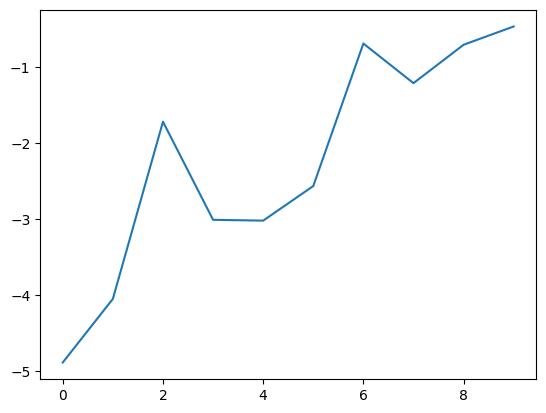

In [13]:
plt.plot(entropies_hm)